### ============================================================================
### NOTEBOOK 02: EXPLORATORY DATA ANALYSIS & FEATURE ENGINEERING
### ============================================================================
### This notebook covers:
###   - 01: EDA - Business Questions (revenue, customers, products, delivery)
###   - 02: EDA - Statistical Analysis (correlations, time series, hypothesis testing)
###   - 03: Feature Engineering (RFM, behavioral, product, seller features)
### ============================================================================

In [24]:
# Setup and Load Clean Data
# ============================================================================
# Import libraries and load the cleaned datasets from Notebook 01
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from pathlib import Path
from datetime import datetime, timedelta
from scipy import stats

# Suppress warnings
warnings.filterwarnings('ignore')

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Configure plotting
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

# Create directories for outputs
Path('reports/figures/eda').mkdir(parents=True, exist_ok=True)
Path('data/features').mkdir(parents=True, exist_ok=True)

print("✅ Libraries imported successfully")
print(f"📅 Analysis date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Libraries imported successfully
📅 Analysis date: 2025-11-09 17:00:49


In [25]:
# Load Clean Datasets
# ============================================================================
# Load the cleaned master datasets created in Notebook 01
# ============================================================================

print("📂 LOADING CLEAN DATASETS\n")
print("="*80)

# Load ORDER-LEVEL dataset (for customer/order analysis)
master_order = pd.read_csv('data/processed/master_order_clean.csv')

# Convert dates back to datetime
date_cols = [
    'order_purchase_timestamp', 'order_approved_at', 
    'order_delivered_carrier_date', 'order_delivered_customer_date',
    'order_estimated_delivery_date', 'review_creation_date'
]

for col in date_cols:
    if col in master_order.columns:
        master_order[col] = pd.to_datetime(master_order[col], errors='coerce')

print(f"✅ ORDER-LEVEL loaded: {master_order.shape}")

# Load ITEM-LEVEL dataset (for product/seller analysis)
master_item = pd.read_csv('data/processed/master_item_clean.csv')

# Convert dates
date_cols_item = date_cols + ['shipping_limit_date']
for col in date_cols_item:
    if col in master_item.columns:
        master_item[col] = pd.to_datetime(master_item[col], errors='coerce')

print(f"✅ ITEM-LEVEL loaded: {master_item.shape}")

# Quick verification
print(f"\n📊 Dataset Overview:")
print(f"   Date range: {master_order['order_purchase_timestamp'].min().date()} to {master_order['order_purchase_timestamp'].max().date()}")
print(f"   Total orders: {len(master_order):,}")
print(f"   Total items: {len(master_item):,}")
print(f"   Unique customers: {master_order['customer_unique_id'].nunique():,}")
print(f"   Unique products: {master_item['product_id'].nunique():,}")
print(f"   Total revenue: BRL {master_order['total_payment'].sum():,.2f}")

print("\n✅ Data loaded and ready for analysis!")

📂 LOADING CLEAN DATASETS

✅ ORDER-LEVEL loaded: (99441, 42)
✅ ITEM-LEVEL loaded: (112650, 60)

📊 Dataset Overview:
   Date range: 2016-09-04 to 2018-10-17
   Total orders: 99,441
   Total items: 112,650
   Unique customers: 96,096
   Unique products: 32,951
   Total revenue: BRL 16,008,872.12

✅ Data loaded and ready for analysis!



                    SECTION 04: EDA - BUSINESS QUESTIONS

💰 BUSINESS QUESTION 1: REVENUE TRENDS

Analyzing 96,476 delivered orders
Revenue: BRL 15,421,831.43

📈 Monthly Revenue Summary:
   year_month_str    revenue  order_count  revenue_growth
13        2017-11 1153393.22         7288           53.55
14        2017-12  843199.17         5513          -26.89
15        2018-01 1078606.86         7069           27.92
16        2018-02  966554.97         6556          -10.39
17        2018-03 1120678.00         7003           15.95
18        2018-04 1132933.95         6798            1.09
19        2018-05 1128836.69         6749           -0.36
20        2018-06 1011561.35         6096          -10.39
21        2018-07 1027383.10         6156            1.56
22        2018-08  985414.28         6351           -4.09

📊 Key Metrics:
   Average monthly revenue: BRL 670,514.41
   Peak month: 2017-11 (BRL 1,153,393.22)
   Lowest month: 2016-09 (BRL 0.00)
   Average MoM growth: inf%


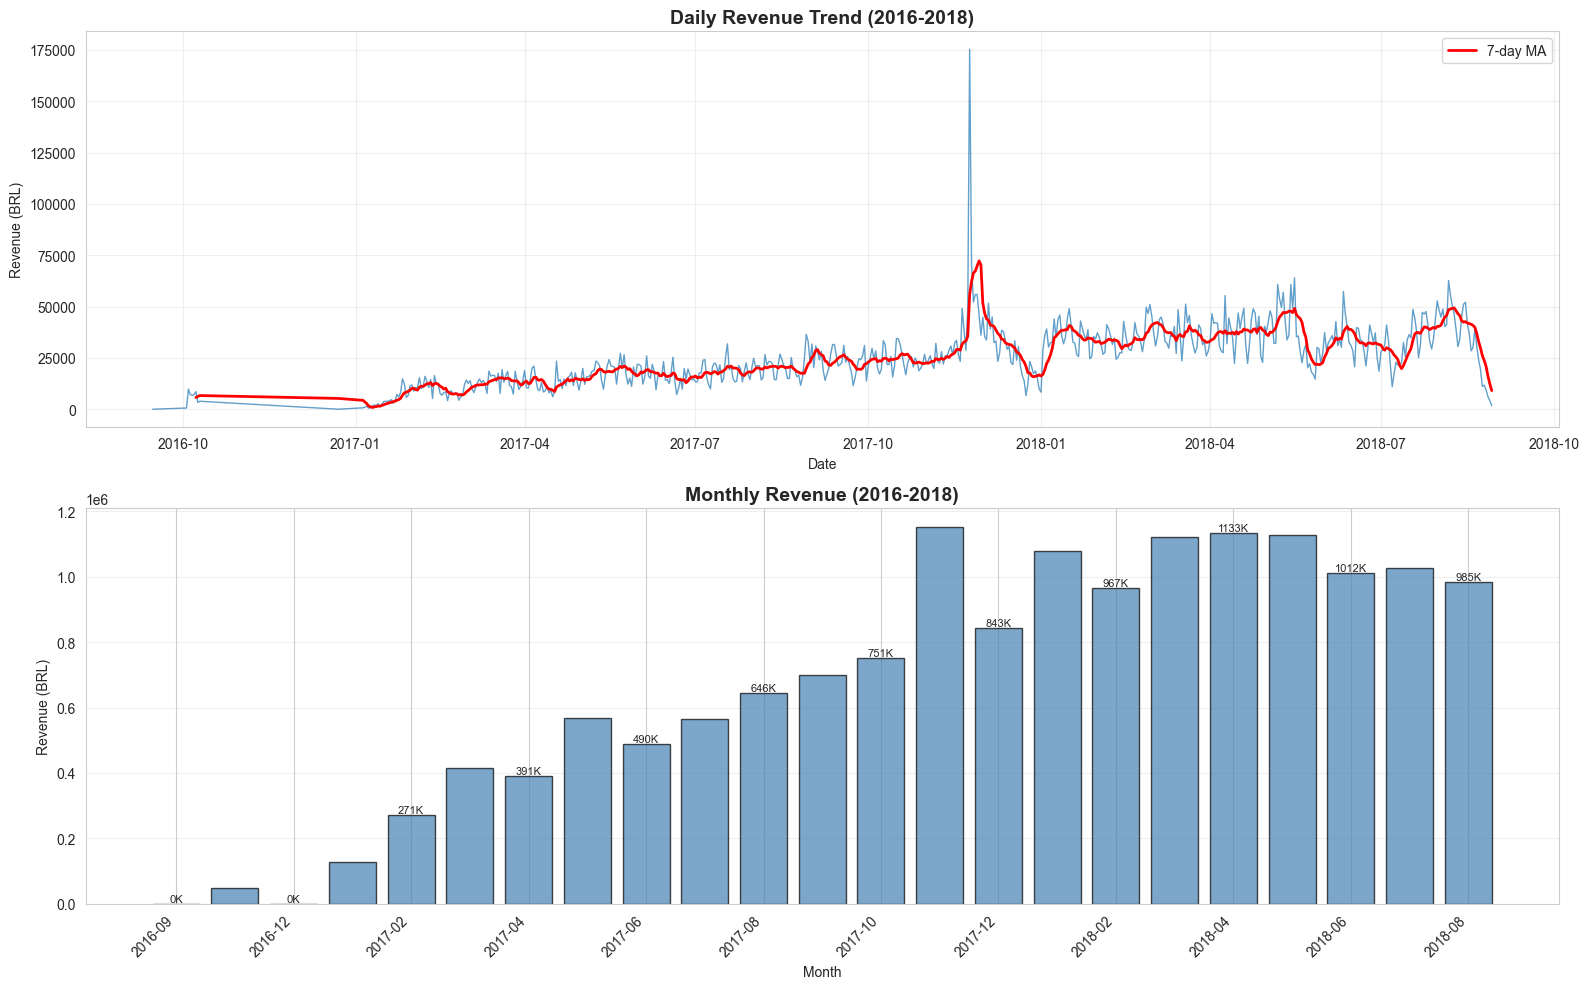


✅ Revenue trend analysis complete
💾 Saved: reports/figures/eda/revenue_trends.png


In [26]:
# Business Question 1 - Revenue Trends
# ============================================================================
# Q: What is the revenue trend over time? Are there seasonal patterns?
# ============================================================================

print("\n" + "="*80)
print(" "*20 + "SECTION 04: EDA - BUSINESS QUESTIONS")
print("="*80)

print("\n💰 BUSINESS QUESTION 1: REVENUE TRENDS")
print("="*80)

# Filter delivered orders for revenue analysis
delivered_orders = master_order[master_order['is_delivered'] == 1].copy()

print(f"\nAnalyzing {len(delivered_orders):,} delivered orders")
print(f"Revenue: BRL {delivered_orders['total_payment'].sum():,.2f}")

# Daily revenue
daily_revenue = delivered_orders.groupby(delivered_orders['order_purchase_timestamp'].dt.date).agg({
    'total_payment': 'sum',
    'order_id': 'count'
}).reset_index()

daily_revenue.columns = ['date', 'revenue', 'order_count']
daily_revenue['date'] = pd.to_datetime(daily_revenue['date'])

# Monthly revenue
delivered_orders['year_month'] = delivered_orders['order_purchase_timestamp'].dt.to_period('M')
monthly_revenue = delivered_orders.groupby('year_month').agg({
    'total_payment': 'sum',
    'order_id': 'count'
}).reset_index()

monthly_revenue.columns = ['year_month', 'revenue', 'order_count']
monthly_revenue['year_month_str'] = monthly_revenue['year_month'].astype(str)

# Calculate growth rates
monthly_revenue['revenue_growth'] = monthly_revenue['revenue'].pct_change() * 100
monthly_revenue['order_growth'] = monthly_revenue['order_count'].pct_change() * 100

print("\n📈 Monthly Revenue Summary:")
print(monthly_revenue[['year_month_str', 'revenue', 'order_count', 'revenue_growth']].tail(10))

print(f"\n📊 Key Metrics:")
print(f"   Average monthly revenue: BRL {monthly_revenue['revenue'].mean():,.2f}")
print(f"   Peak month: {monthly_revenue.loc[monthly_revenue['revenue'].idxmax(), 'year_month_str']} (BRL {monthly_revenue['revenue'].max():,.2f})")
print(f"   Lowest month: {monthly_revenue.loc[monthly_revenue['revenue'].idxmin(), 'year_month_str']} (BRL {monthly_revenue['revenue'].min():,.2f})")
print(f"   Average MoM growth: {monthly_revenue['revenue_growth'].mean():.2f}%")

# Visualize daily revenue trend
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Daily revenue
axes[0].plot(daily_revenue['date'], daily_revenue['revenue'], linewidth=1, alpha=0.7)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Revenue (BRL)')
axes[0].set_title('Daily Revenue Trend (2016-2018)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Add 7-day moving average
daily_revenue['revenue_ma7'] = daily_revenue['revenue'].rolling(window=7).mean()
axes[0].plot(daily_revenue['date'], daily_revenue['revenue_ma7'], color='red', linewidth=2, label='7-day MA')
axes[0].legend()

# Monthly revenue with bars
x_pos = np.arange(len(monthly_revenue))
axes[1].bar(x_pos, monthly_revenue['revenue'], color='steelblue', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Revenue (BRL)')
axes[1].set_title('Monthly Revenue (2016-2018)', fontsize=14, fontweight='bold')
axes[1].set_xticks(x_pos[::2])  # Show every other month
axes[1].set_xticklabels(monthly_revenue['year_month_str'].iloc[::2], rotation=45, ha='right')
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on top of bars
for i, v in enumerate(monthly_revenue['revenue']):
    if i % 2 == 0:  # Label every other bar to avoid clutter
        axes[1].text(i, v, f'{v/1000:.0f}K', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('reports/figures/eda/revenue_trends.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Revenue trend analysis complete")
print("💾 Saved: reports/figures/eda/revenue_trends.png")


📅 BUSINESS QUESTION 2: SEASONALITY ANALYSIS

📊 Revenue by Month:
    month month_name        sum   mean  count
0       1    January 1206152.53 154.26   7819
1       2   February 1237853.62 150.79   8209
2       3      March 1535047.39 160.75   9549
3       4      April 1523886.13 167.44   9101
4       5        May 1695709.42 164.73  10294
5       6       June 1501786.95 162.69   9231
6       7       July 1593787.03 158.93  10028
7       8     August 1631414.89 154.72  10544
8       9  September  701169.99 168.96   4150
9      10    October  798411.47 168.16   4748
10     11   November 1153393.22 158.26   7288
11     12   December  843218.79 152.92   5514

📊 Revenue by Day of Week:
   day_of_week   day_name        sum   mean  count
0            0     Monday 2530671.56 161.16  15703
1            1    Tuesday 2473930.77 159.59  15502
2            2  Wednesday 2396215.34 158.96  15074
3            3   Thursday 2283964.44 159.48  14321
4            4     Friday 2223022.52 162.44  13685
5  

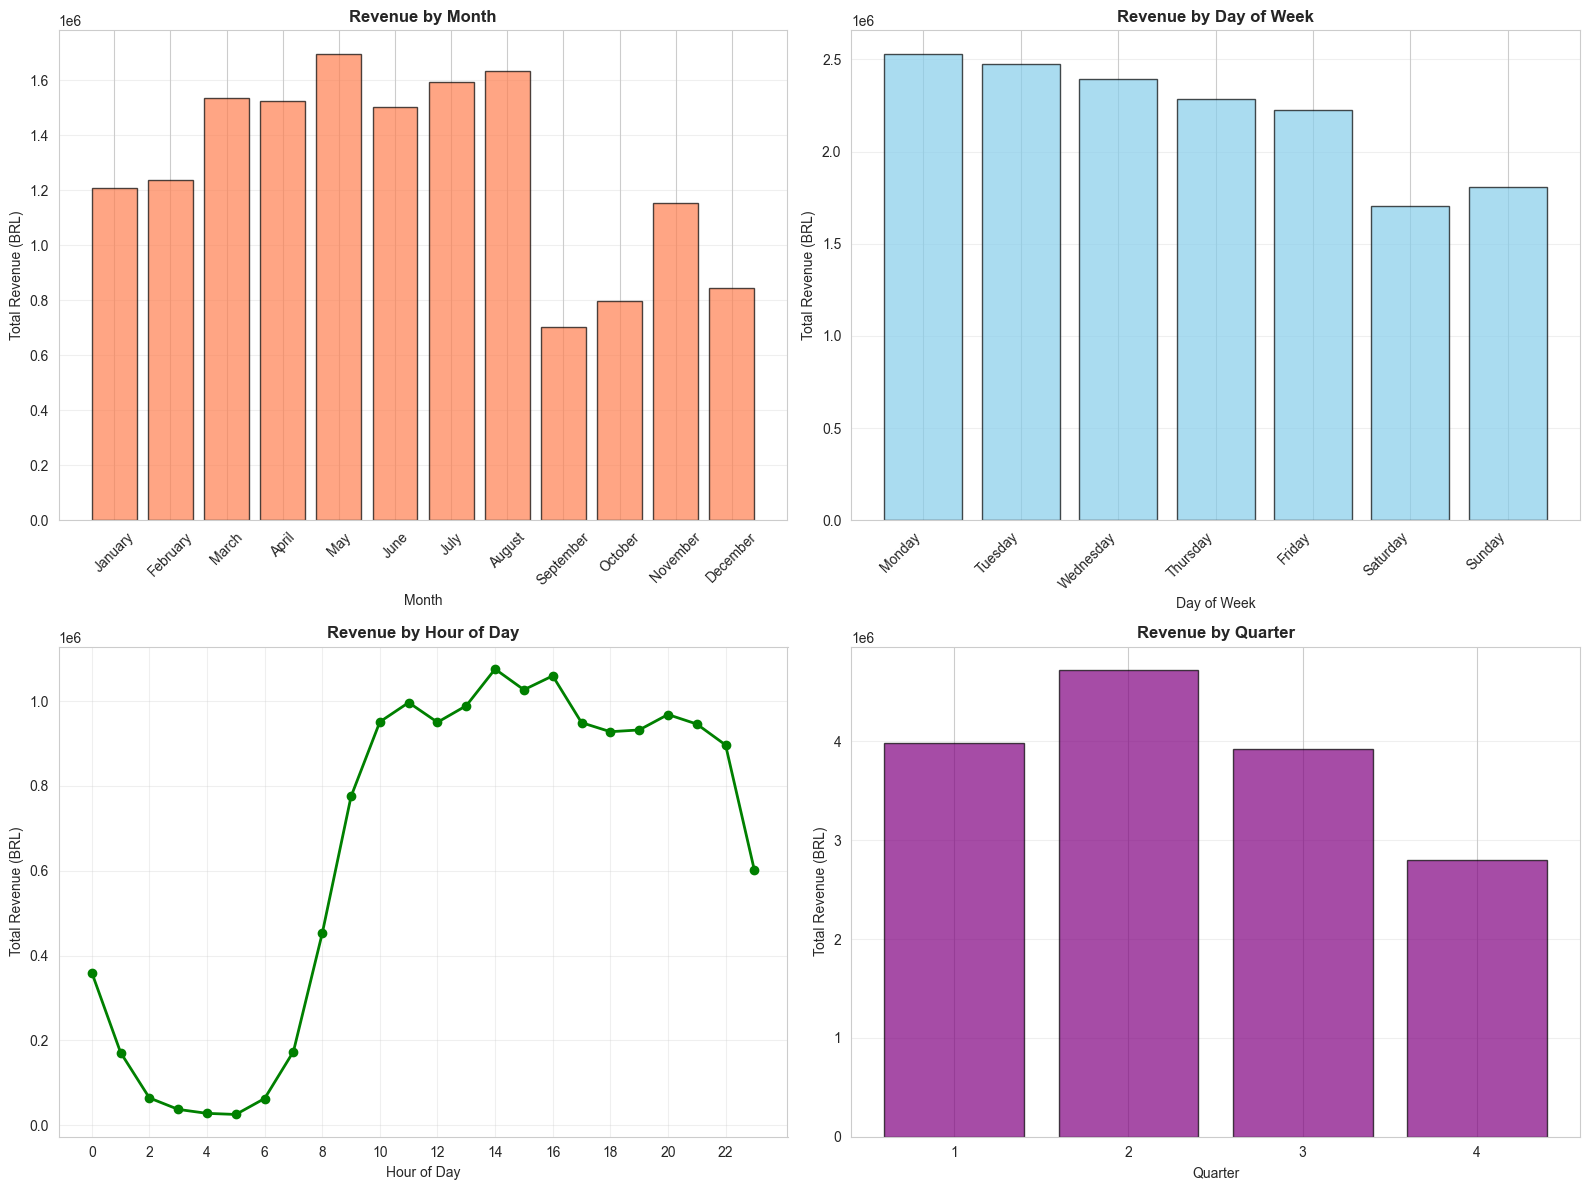


✅ Seasonality analysis complete
💾 Saved: reports/figures/eda/seasonality_patterns.png

🔑 KEY INSIGHTS:
   • Best month: May
   • Best day: Monday
   • Peak hour: 14:00
   • Best quarter: Q2


In [27]:
# Business Question 2 - Seasonality Analysis
# ============================================================================
# Q: Are there seasonal patterns? Which months/days perform best?
# ============================================================================

print("\n📅 BUSINESS QUESTION 2: SEASONALITY ANALYSIS")
print("="*80)

# Extract time components
delivered_orders['month'] = delivered_orders['order_purchase_timestamp'].dt.month
delivered_orders['month_name'] = delivered_orders['order_purchase_timestamp'].dt.month_name()
delivered_orders['day_of_week'] = delivered_orders['order_purchase_timestamp'].dt.dayofweek
delivered_orders['day_name'] = delivered_orders['order_purchase_timestamp'].dt.day_name()
delivered_orders['hour'] = delivered_orders['order_purchase_timestamp'].dt.hour
delivered_orders['quarter'] = delivered_orders['order_purchase_timestamp'].dt.quarter

# Revenue by month
revenue_by_month = delivered_orders.groupby(['month', 'month_name'])['total_payment'].agg(['sum', 'mean', 'count']).reset_index()
revenue_by_month = revenue_by_month.sort_values('month')

print("\n📊 Revenue by Month:")
print(revenue_by_month)

# Revenue by day of week
revenue_by_dow = delivered_orders.groupby(['day_of_week', 'day_name'])['total_payment'].agg(['sum', 'mean', 'count']).reset_index()
revenue_by_dow = revenue_by_dow.sort_values('day_of_week')

print("\n📊 Revenue by Day of Week:")
print(revenue_by_dow)

# Revenue by hour
revenue_by_hour = delivered_orders.groupby('hour')['total_payment'].agg(['sum', 'mean', 'count']).reset_index()

print("\n📊 Peak Hours:")
print(revenue_by_hour.nlargest(5, 'sum'))

# Check for Black Friday effect (late November)
delivered_orders['is_black_friday_week'] = (
    (delivered_orders['month'] == 11) & 
    (delivered_orders['order_purchase_timestamp'].dt.day >= 20) & 
    (delivered_orders['order_purchase_timestamp'].dt.day <= 27)
)

bf_revenue = delivered_orders[delivered_orders['is_black_friday_week']]['total_payment'].sum()
non_bf_revenue = delivered_orders[~delivered_orders['is_black_friday_week']]['total_payment'].sum()
bf_orders = delivered_orders[delivered_orders['is_black_friday_week']]['order_id'].count()
total_orders = len(delivered_orders)

print(f"\n🛍️ BLACK FRIDAY IMPACT:")
print(f"   Black Friday week orders: {bf_orders:,} ({bf_orders/total_orders*100:.2f}%)")
print(f"   Black Friday week revenue: BRL {bf_revenue:,.2f} ({bf_revenue/(bf_revenue+non_bf_revenue)*100:.2f}%)")

# Visualize seasonality
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Monthly pattern
axes[0, 0].bar(revenue_by_month['month_name'], revenue_by_month['sum'], color='coral', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Total Revenue (BRL)')
axes[0, 0].set_title('Revenue by Month', fontsize=12, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Day of week pattern
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
axes[0, 1].bar(revenue_by_dow['day_name'], revenue_by_dow['sum'], color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('Total Revenue (BRL)')
axes[0, 1].set_title('Revenue by Day of Week', fontsize=12, fontweight='bold')
axes[0, 1].set_xticklabels(day_order, rotation=45, ha='right')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Hourly pattern
axes[1, 0].plot(revenue_by_hour['hour'], revenue_by_hour['sum'], marker='o', linewidth=2, color='green')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Total Revenue (BRL)')
axes[1, 0].set_title('Revenue by Hour of Day', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(range(0, 24, 2))
axes[1, 0].grid(True, alpha=0.3)

# Quarterly pattern
revenue_by_quarter = delivered_orders.groupby('quarter')['total_payment'].sum()
axes[1, 1].bar(revenue_by_quarter.index, revenue_by_quarter.values, color='purple', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Quarter')
axes[1, 1].set_ylabel('Total Revenue (BRL)')
axes[1, 1].set_title('Revenue by Quarter', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks([1, 2, 3, 4])
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('reports/figures/eda/seasonality_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Seasonality analysis complete")
print("💾 Saved: reports/figures/eda/seasonality_patterns.png")

# Key insights
print("\n🔑 KEY INSIGHTS:")
print(f"   • Best month: {revenue_by_month.loc[revenue_by_month['sum'].idxmax(), 'month_name']}")
print(f"   • Best day: {revenue_by_dow.loc[revenue_by_dow['sum'].idxmax(), 'day_name']}")
print(f"   • Peak hour: {revenue_by_hour.loc[revenue_by_hour['sum'].idxmax(), 'hour']}:00")
print(f"   • Best quarter: Q{revenue_by_quarter.idxmax()}")


👥 BUSINESS QUESTION 3: CUSTOMER BEHAVIOR

📊 CUSTOMER METRICS:
   Total unique customers: 93,356
   Customers with 1 order: 90,555 (97.00%)
   Customers with 2+ orders: 2,801 (3.00%)
   Repeat purchase rate: 3.00%
   Max orders by single customer: 15

💰 CUSTOMER LIFETIME VALUE:
count   93356.00
mean      165.19
std       226.32
min         0.00
25%        63.05
50%       107.78
75%       182.54
90%       318.03
95%       469.63
99%      1097.07
max     13664.08
Name: total_spent, dtype: float64

📈 AVERAGE ORDER VALUE:
count   93356.00
mean      160.31
std       219.57
min         0.00
25%        62.37
50%       105.63
75%       176.65
90%       306.22
95%       447.00
99%      1057.24
max     13664.08
Name: avg_order_value, dtype: float64

📊 CUSTOMER SEGMENTS:
      customer_segment customer_unique_id total_spent        order_count
                                    count         sum   mean         sum
0  Loyal Customer (6+)                 10     8409.06 840.91          75
1       On

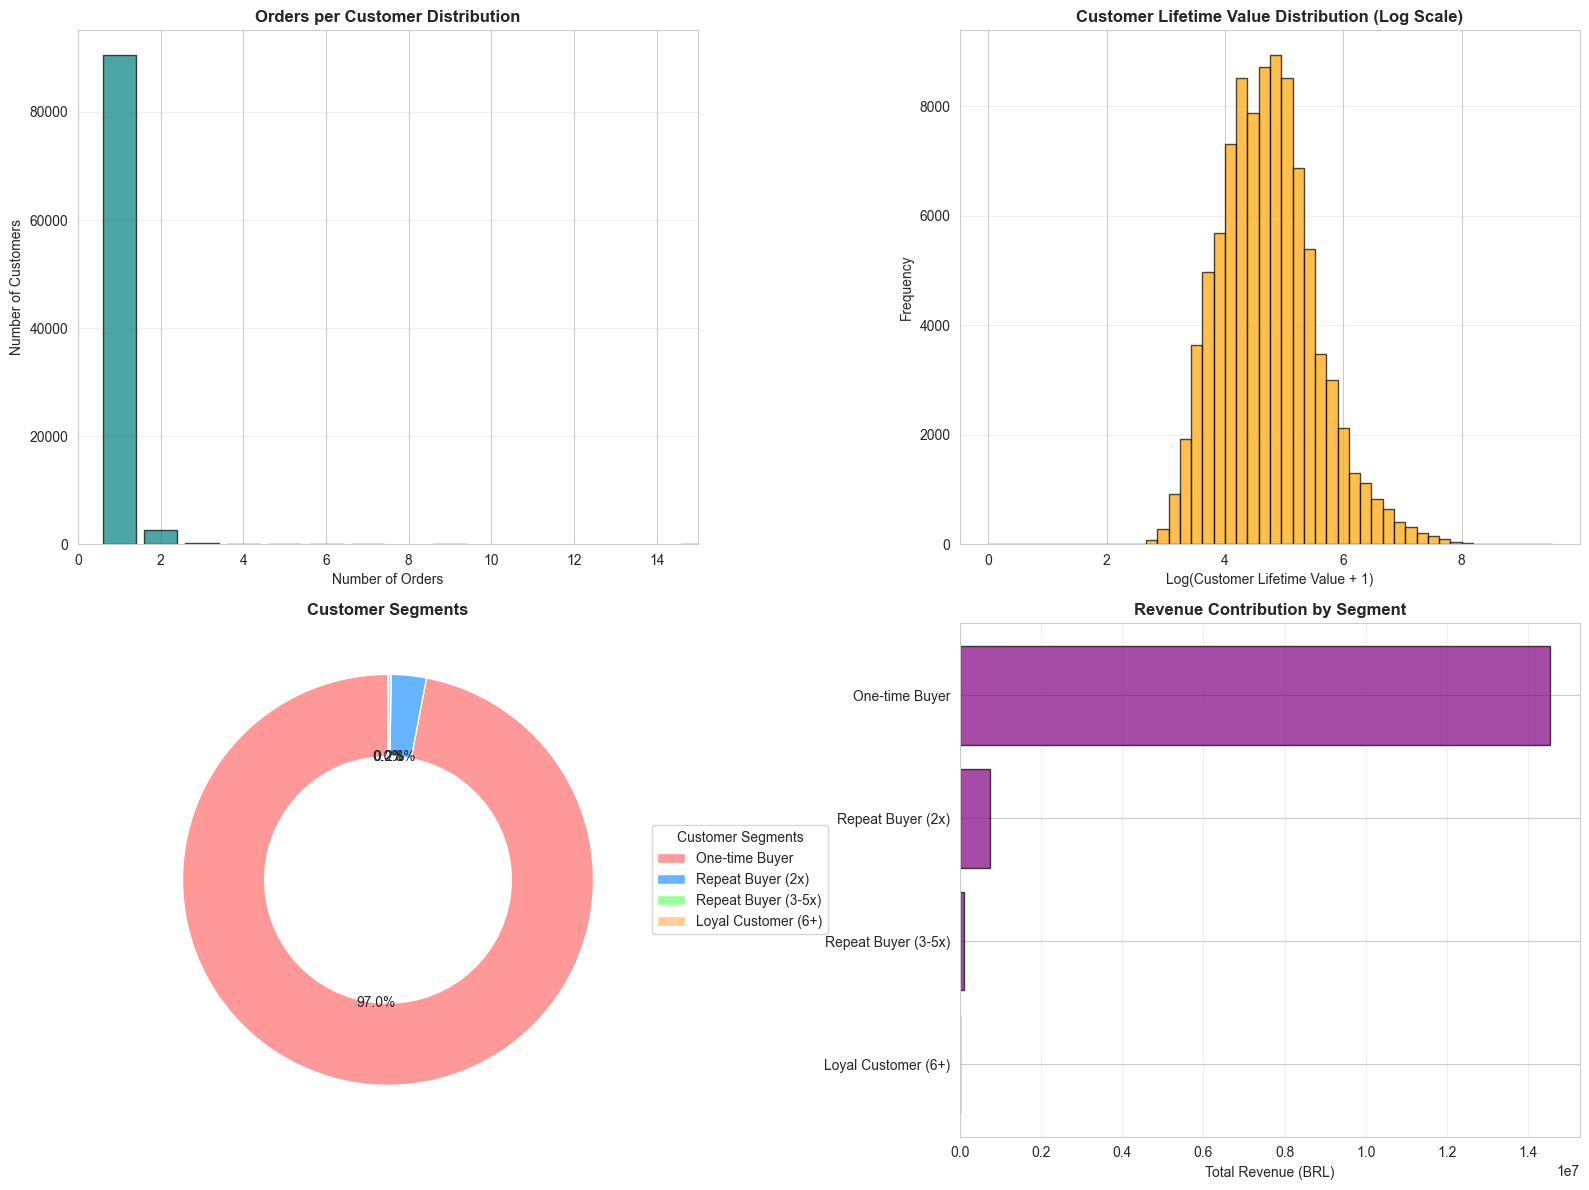


✅ Customer behavior analysis complete
💾 Saved: reports/figures/eda/customer_behavior.png

⚠️  CRITICAL INSIGHT:
   97.0% of customers make ONLY ONE purchase!
   This indicates a MAJOR retention problem - focus area for improvement


In [28]:
# Business Question 3 - Customer Behavior
# ============================================================================
# Q: What is the repeat purchase rate? Customer lifetime value distribution?
# ============================================================================

print("\n👥 BUSINESS QUESTION 3: CUSTOMER BEHAVIOR")
print("="*80)

# Calculate orders per customer (using customer_unique_id)
orders_per_customer = delivered_orders.groupby('customer_unique_id').agg({
    'order_id': 'count',
    'total_payment': 'sum',
    'order_purchase_timestamp': ['min', 'max']
}).reset_index()

orders_per_customer.columns = ['customer_unique_id', 'order_count', 'total_spent', 'first_order_date', 'last_order_date']

# Calculate customer tenure
orders_per_customer['customer_tenure_days'] = (
    orders_per_customer['last_order_date'] - orders_per_customer['first_order_date']
).dt.days

# Calculate CLV metrics
orders_per_customer['avg_order_value'] = orders_per_customer['total_spent'] / orders_per_customer['order_count']

print(f"\n📊 CUSTOMER METRICS:")
print(f"   Total unique customers: {len(orders_per_customer):,}")
print(f"   Customers with 1 order: {(orders_per_customer['order_count'] == 1).sum():,} ({(orders_per_customer['order_count'] == 1).sum()/len(orders_per_customer)*100:.2f}%)")
print(f"   Customers with 2+ orders: {(orders_per_customer['order_count'] >= 2).sum():,} ({(orders_per_customer['order_count'] >= 2).sum()/len(orders_per_customer)*100:.2f}%)")
print(f"   Repeat purchase rate: {(orders_per_customer['order_count'] > 1).sum()/len(orders_per_customer)*100:.2f}%")
print(f"   Max orders by single customer: {orders_per_customer['order_count'].max()}")

print(f"\n💰 CUSTOMER LIFETIME VALUE:")
print(orders_per_customer['total_spent'].describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99]))

print(f"\n📈 AVERAGE ORDER VALUE:")
print(orders_per_customer['avg_order_value'].describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99]))

# Segment customers
def segment_customer(row):
    if row['order_count'] == 1:
        return 'One-time Buyer'
    elif row['order_count'] == 2:
        return 'Repeat Buyer (2x)'
    elif row['order_count'] <= 5:
        return 'Repeat Buyer (3-5x)'
    else:
        return 'Loyal Customer (6+)'

orders_per_customer['customer_segment'] = orders_per_customer.apply(segment_customer, axis=1)

segment_summary = orders_per_customer.groupby('customer_segment').agg({
    'customer_unique_id': 'count',
    'total_spent': ['sum', 'mean'],
    'order_count': 'sum'
}).reset_index()

print(f"\n📊 CUSTOMER SEGMENTS:")
print(segment_summary)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Orders per customer distribution
order_counts = orders_per_customer['order_count'].value_counts().sort_index()
axes[0, 0].bar(order_counts.index, order_counts.values, color='teal', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Number of Orders')
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].set_title('Orders per Customer Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlim(0, min(15, order_counts.index.max()))
axes[0, 0].grid(True, alpha=0.3, axis='y')

# CLV distribution (log scale)
axes[0, 1].hist(np.log1p(orders_per_customer['total_spent']), bins=50, color='orange', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Log(Customer Lifetime Value + 1)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Customer Lifetime Value Distribution (Log Scale)', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# ✅ Improved Customer Segments (Donut Chart + Legend)
segment_counts = orders_per_customer['customer_segment'].value_counts()
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']

wedges, texts, autotexts = axes[1, 0].pie(
    segment_counts.values,
    labels=None,
    autopct='%1.1f%%',
    colors=colors,
    startangle=90,
    wedgeprops=dict(width=0.4, edgecolor='white')
)

# Add legend outside for readability
axes[1, 0].legend(
    segment_counts.index,
    title="Customer Segments",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

axes[1, 0].set_title('Customer Segments', fontsize=12, fontweight='bold')
axes[1, 0].set_aspect('equal')

# Revenue by segment
segment_revenue = orders_per_customer.groupby('customer_segment')['total_spent'].sum().sort_values(ascending=True)
axes[1, 1].barh(range(len(segment_revenue)), segment_revenue.values, color='purple', edgecolor='black', alpha=0.7)
axes[1, 1].set_yticks(range(len(segment_revenue)))
axes[1, 1].set_yticklabels(segment_revenue.index)
axes[1, 1].set_xlabel('Total Revenue (BRL)')
axes[1, 1].set_title('Revenue Contribution by Segment', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('reports/figures/eda/customer_behavior.png', dpi=300, bbox_inches='tight')
plt.show()


print("\n✅ Customer behavior analysis complete")
print("💾 Saved: reports/figures/eda/customer_behavior.png")

# Critical insight
print("\n⚠️  CRITICAL INSIGHT:")
one_time_pct = (orders_per_customer['order_count'] == 1).sum()/len(orders_per_customer)*100
print(f"   {one_time_pct:.1f}% of customers make ONLY ONE purchase!")
print(f"   This indicates a MAJOR retention problem - focus area for improvement")


🛍️ BUSINESS QUESTION 4: PRODUCT PERFORMANCE

📊 Top 15 Categories by Revenue:
                 category  total_revenue  total_items_sold  avg_price
43          health_beauty     1258681.34              9670     130.16
71          watches_gifts     1205005.68              5991     201.14
7          bed_bath_table     1036988.68             11115      93.30
65         sports_leisure      988048.97              8641     114.34
15  computers_accessories      911954.32              7827     116.51
39        furniture_decor      729762.49              8334      87.56
20             cool_stuff      635290.85              3796     167.36
49             housewares      632248.66              6964      90.79
5                    auto      592720.11              4235     139.96
42           garden_tools      485256.46              4347     111.63
69                   toys      483946.60              4117     117.55
6                    baby      411764.89              3065     134.34
59          

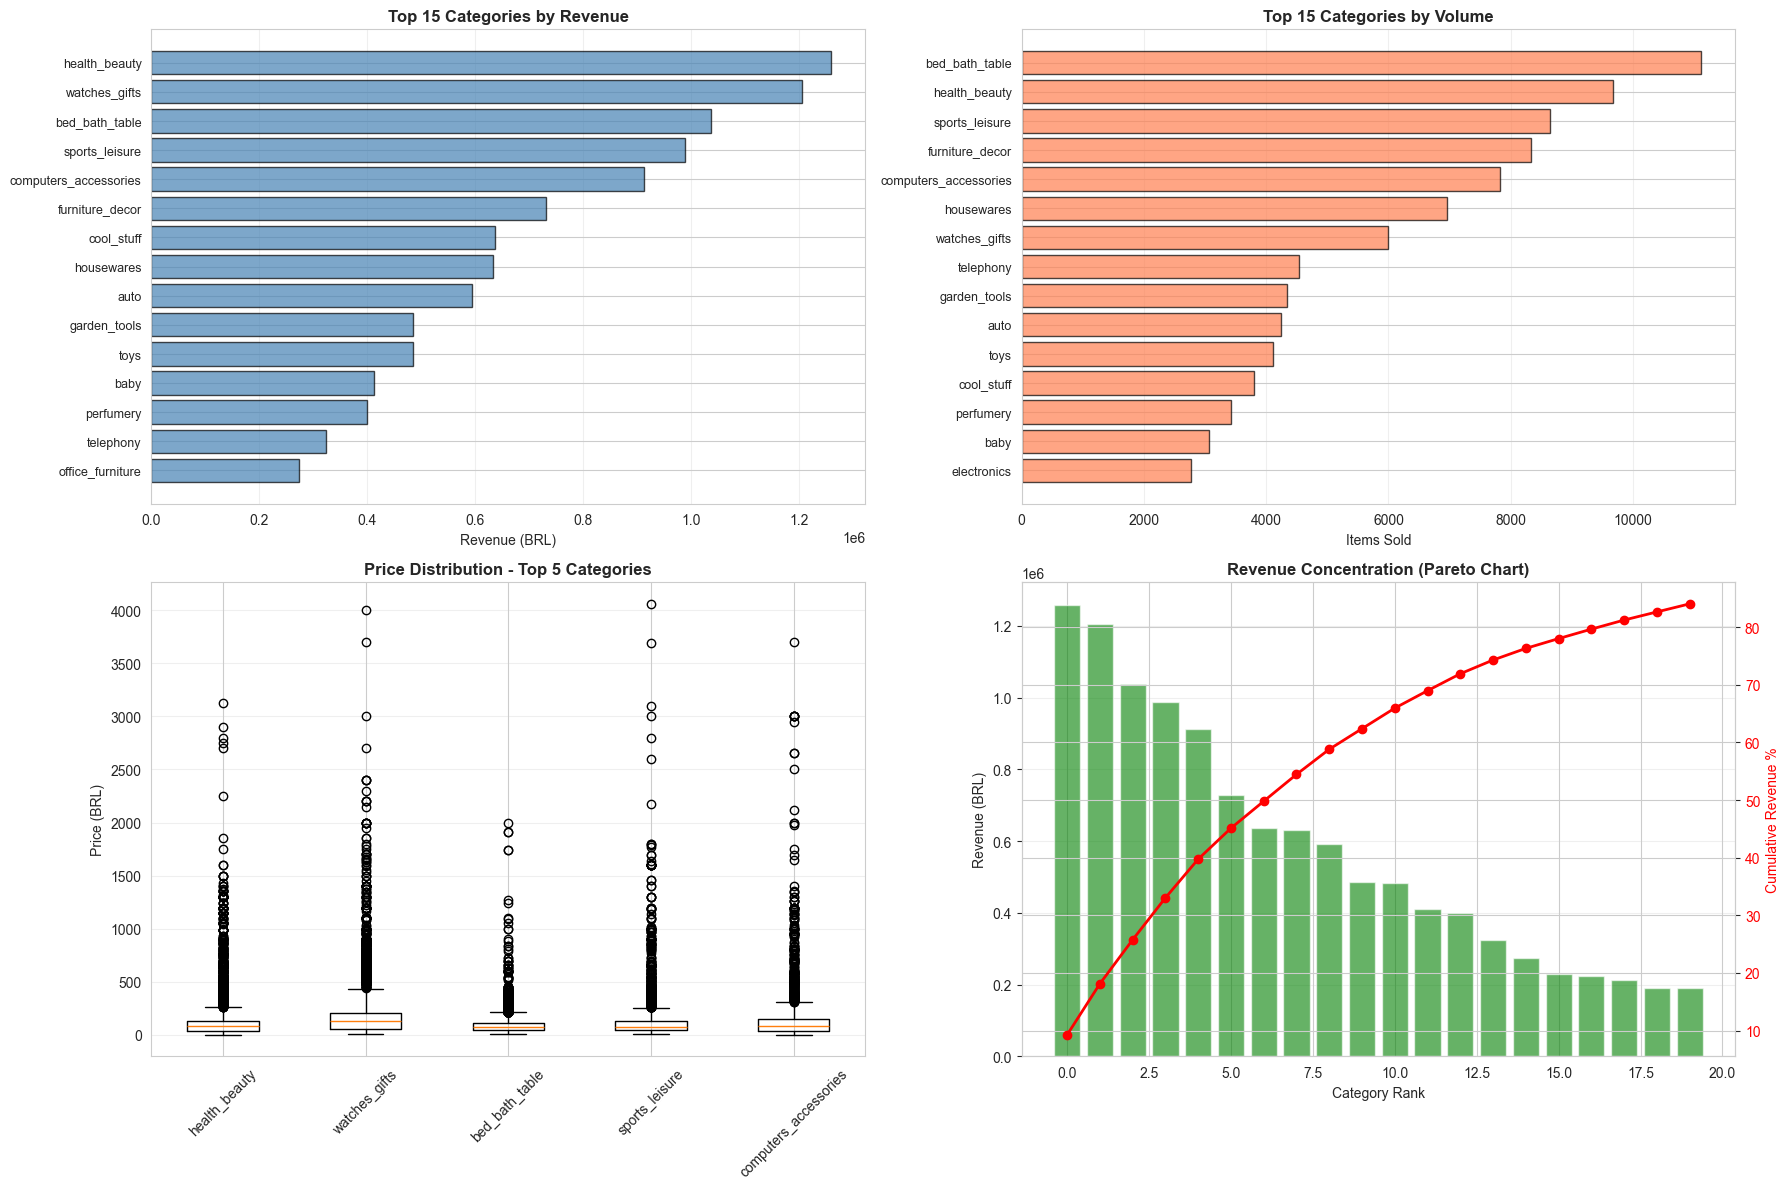


✅ Product performance analysis complete
💾 Saved: reports/figures/eda/product_performance.png


In [29]:
# Business Question 4 - Product Performance
# ============================================================================
# Q: Which product categories drive revenue? Which are most popular?
# ============================================================================

print("\n🛍️ BUSINESS QUESTION 4: PRODUCT PERFORMANCE")
print("="*80)

# Analyze by category
category_performance = master_item.groupby('product_category_name_english').agg({
    'order_id': 'count',
    'price': ['sum', 'mean'],
    'product_id': 'nunique'
}).reset_index()

category_performance.columns = ['category', 'total_items_sold', 'total_revenue', 'avg_price', 'unique_products']
category_performance = category_performance.sort_values('total_revenue', ascending=False)

print(f"\n📊 Top 15 Categories by Revenue:")
print(category_performance.head(15)[['category', 'total_revenue', 'total_items_sold', 'avg_price']])

print(f"\n📊 Top 15 Categories by Volume:")
print(category_performance.sort_values('total_items_sold', ascending=False).head(15)[['category', 'total_items_sold', 'total_revenue']])

# Calculate category concentration
top_10_revenue = category_performance.head(10)['total_revenue'].sum()
total_revenue_cat = category_performance['total_revenue'].sum()
print(f"\n📈 Category Concentration:")
print(f"   Top 10 categories: BRL {top_10_revenue:,.2f} ({top_10_revenue/total_revenue_cat*100:.1f}% of total)")
print(f"   Total categories: {len(category_performance)}")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Top 15 by revenue
top_15_rev = category_performance.head(15)
axes[0, 0].barh(range(len(top_15_rev)), top_15_rev['total_revenue'], color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_yticks(range(len(top_15_rev)))
axes[0, 0].set_yticklabels(top_15_rev['category'], fontsize=9)
axes[0, 0].set_xlabel('Revenue (BRL)')
axes[0, 0].set_title('Top 15 Categories by Revenue', fontsize=12, fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(True, alpha=0.3, axis='x')

# Top 15 by volume
top_15_vol = category_performance.sort_values('total_items_sold', ascending=False).head(15)
axes[0, 1].barh(range(len(top_15_vol)), top_15_vol['total_items_sold'], color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_yticks(range(len(top_15_vol)))
axes[0, 1].set_yticklabels(top_15_vol['category'], fontsize=9)
axes[0, 1].set_xlabel('Items Sold')
axes[0, 1].set_title('Top 15 Categories by Volume', fontsize=12, fontweight='bold')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(True, alpha=0.3, axis='x')

# Price distribution by top categories
top_5_categories = category_performance.head(5)['category'].tolist()
price_data_top5 = master_item[master_item['product_category_name_english'].isin(top_5_categories)]

axes[1, 0].boxplot([price_data_top5[price_data_top5['product_category_name_english'] == cat]['price'].dropna() 
                     for cat in top_5_categories], 
                    labels=top_5_categories, vert=True)
axes[1, 0].set_ylabel('Price (BRL)')
axes[1, 0].set_title('Price Distribution - Top 5 Categories', fontsize=12, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Revenue concentration (Pareto chart)
category_performance_sorted = category_performance.sort_values('total_revenue', ascending=False).reset_index(drop=True)
category_performance_sorted['cumulative_revenue'] = category_performance_sorted['total_revenue'].cumsum()
category_performance_sorted['cumulative_pct'] = (category_performance_sorted['cumulative_revenue'] / 
                                                  category_performance_sorted['total_revenue'].sum() * 100)

axes[1, 1].bar(range(20), category_performance_sorted.head(20)['total_revenue'], color='green', alpha=0.6, label='Revenue')
ax2 = axes[1, 1].twinx()
ax2.plot(range(20), category_performance_sorted.head(20)['cumulative_pct'], color='red', marker='o', linewidth=2, label='Cumulative %')
ax2.set_ylabel('Cumulative Revenue %', color='red')
ax2.tick_params(axis='y', labelcolor='red')
axes[1, 1].set_xlabel('Category Rank')
axes[1, 1].set_ylabel('Revenue (BRL)')
axes[1, 1].set_title('Revenue Concentration (Pareto Chart)', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('reports/figures/eda/product_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Product performance analysis complete")
print("💾 Saved: reports/figures/eda/product_performance.png")


🚚 BUSINESS QUESTION 5: DELIVERY PERFORMANCE

Analyzing 96,463 delivered orders with valid delivery times

📊 Delivery Time Statistics (days):
count   96463.00
mean       12.10
std         9.55
min         1.00
25%         6.00
50%        10.00
75%        15.00
90%        23.00
95%        29.00
max       209.00
Name: delivery_time_days, dtype: float64

📊 Delivery Performance:
   On-time deliveries: 89,928 (93.2%)
   Late deliveries: 6,535 (6.8%)
   Average delay: -11.88 days
   Median delay: -12.00 days

📊 Top 10 States with Longest Delivery Times:
   state  avg_delivery_time  median_delivery_time  std_delivery_time  \
21    RR              28.98                 25.00              27.79   
3     AP              26.73                 24.00              21.41   
2     AM              25.99                 25.00              13.85   
1     AL              24.04                 22.00              11.48   
13    PA              23.32                 21.00              13.16   
9     MA      

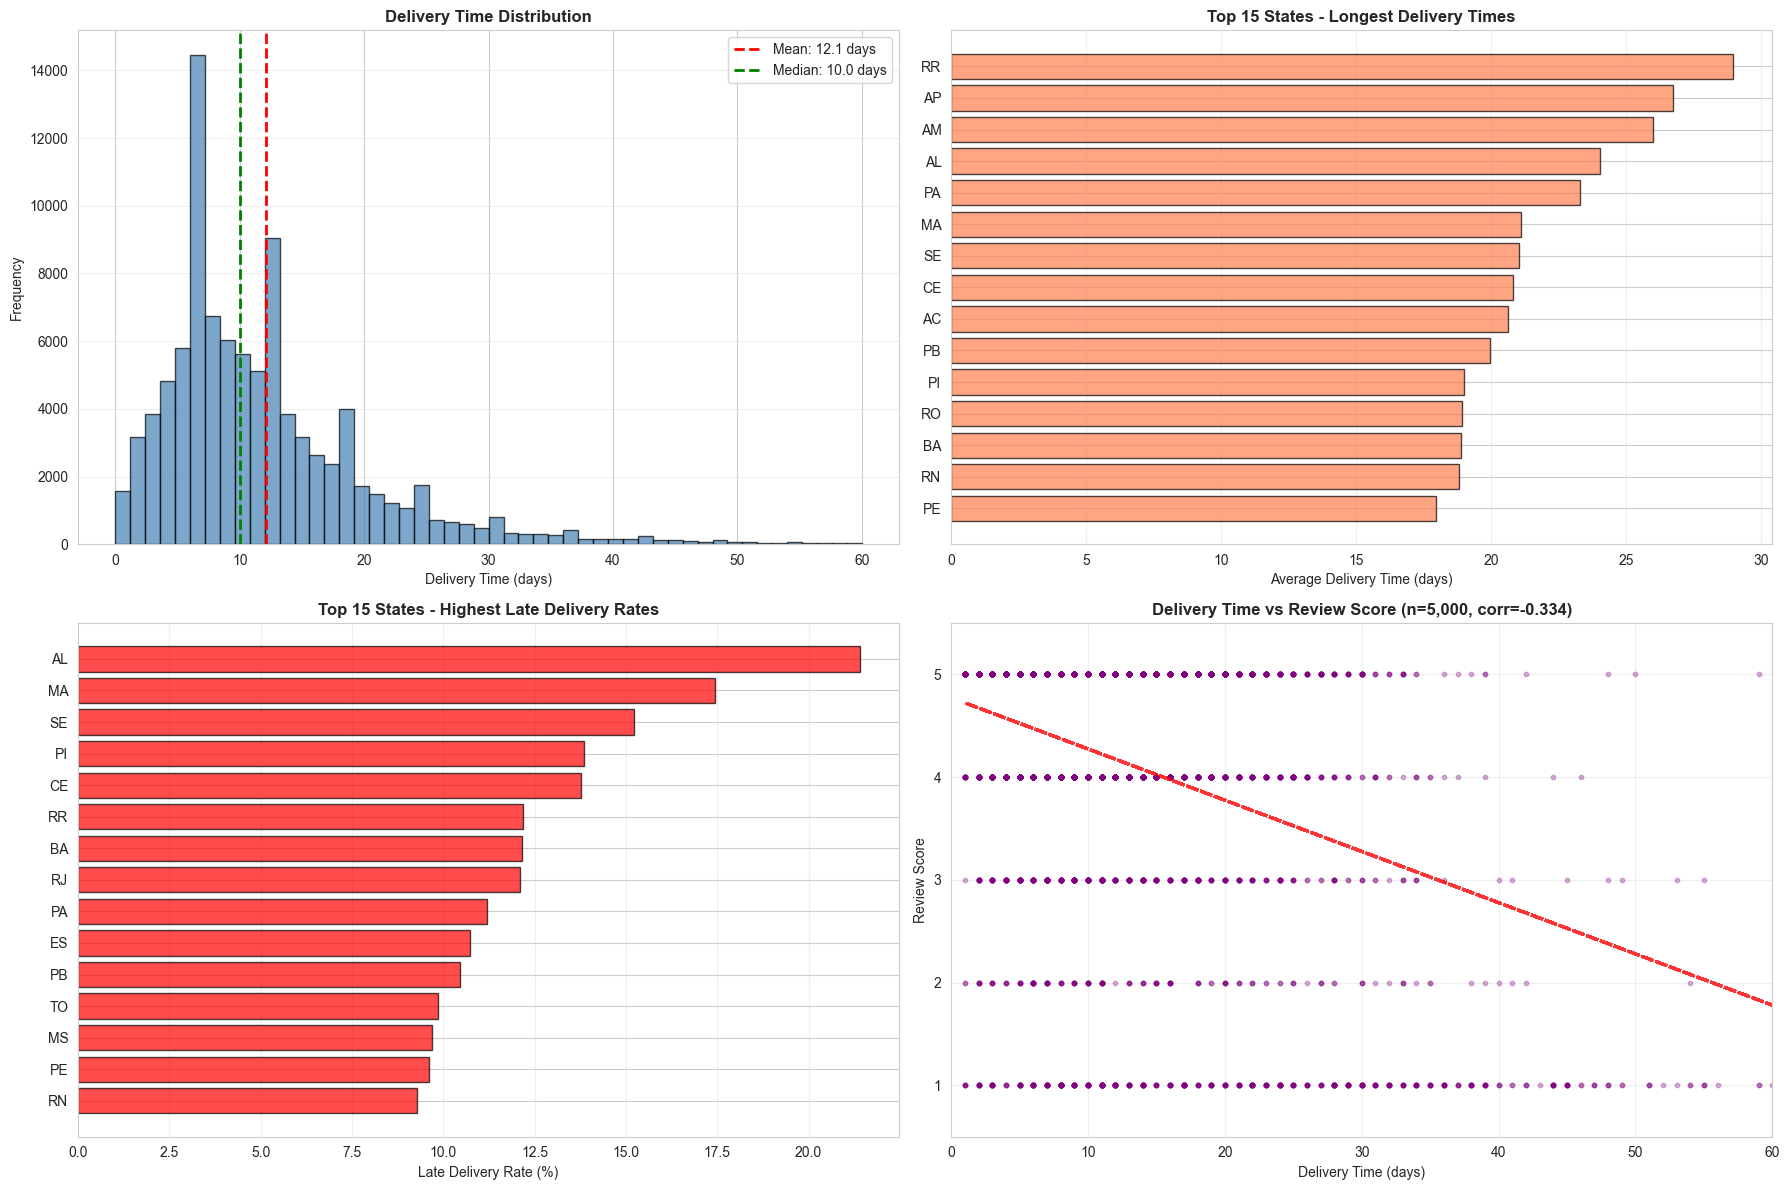


✅ Delivery performance analysis complete
💾 Saved: reports/figures/eda/delivery_performance.png

🔑 KEY INSIGHTS:
   • Average delivery: 12.1 days
   • Late delivery rate: 6.8%
   • Delivery time NEGATIVELY correlates with review scores (faster = better reviews)
   • Remote states have significantly longer delivery times


In [30]:
# Business Question 5 - Delivery Performance
# ============================================================================
# Q: How does delivery performance vary by state? What affects delivery time?
# ============================================================================

print("\n🚚 BUSINESS QUESTION 5: DELIVERY PERFORMANCE")
print("="*80)

# Filter delivered orders with valid delivery times
delivered_with_time = master_order[
    (master_order['is_delivered'] == 1) & 
    (master_order['delivery_time_days'].notna()) &
    (master_order['delivery_time_days'] > 0)
].copy()

print(f"\nAnalyzing {len(delivered_with_time):,} delivered orders with valid delivery times")

print(f"\n📊 Delivery Time Statistics (days):")
print(delivered_with_time['delivery_time_days'].describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95]))

print(f"\n📊 Delivery Performance:")
on_time = (delivered_with_time['delivery_delay_days'] <= 0).sum()
late = (delivered_with_time['delivery_delay_days'] > 0).sum()
print(f"   On-time deliveries: {on_time:,} ({on_time/len(delivered_with_time)*100:.1f}%)")
print(f"   Late deliveries: {late:,} ({late/len(delivered_with_time)*100:.1f}%)")
print(f"   Average delay: {delivered_with_time['delivery_delay_days'].mean():.2f} days")
print(f"   Median delay: {delivered_with_time['delivery_delay_days'].median():.2f} days")

# Delivery by state
delivery_by_state = delivered_with_time.groupby('customer_state').agg({
    'delivery_time_days': ['mean', 'median', 'std'],
    'is_late_delivery': 'mean',
    'order_id': 'count'
}).reset_index()

delivery_by_state.columns = ['state', 'avg_delivery_time', 'median_delivery_time', 'std_delivery_time', 'late_rate', 'order_count']
delivery_by_state = delivery_by_state.sort_values('avg_delivery_time', ascending=False)

print(f"\n📊 Top 10 States with Longest Delivery Times:")
print(delivery_by_state.head(10))

print(f"\n📊 Top 10 States with Shortest Delivery Times:")
print(delivery_by_state.tail(10))

# Correlation between delivery time and review score
delivery_with_review = delivered_with_time[delivered_with_time['has_review'] == 1].copy()
if len(delivery_with_review) > 0:
    corr = delivery_with_review['delivery_time_days'].corr(delivery_with_review['review_score'])
    print(f"\n📈 Correlation between delivery time and review score: {corr:.3f}")
    
    # Average review by delivery time bins
    delivery_with_review['delivery_bin'] = pd.cut(
        delivery_with_review['delivery_time_days'], 
        bins=[0, 5, 10, 15, 20, 30, 100], 
        labels=['0-5', '6-10', '11-15', '16-20', '21-30', '30+']
    )
    
    review_by_delivery = delivery_with_review.groupby('delivery_bin').agg({
        'review_score': ['mean', 'count']
    }).reset_index()
    
    print(f"\n📊 Average Review Score by Delivery Time:")
    print(review_by_delivery)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Delivery time distribution
axes[0, 0].hist(delivered_with_time['delivery_time_days'], bins=50, color='steelblue', edgecolor='black', alpha=0.7, range=(0, 60))
axes[0, 0].axvline(delivered_with_time['delivery_time_days'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {delivered_with_time["delivery_time_days"].mean():.1f} days')
axes[0, 0].axvline(delivered_with_time['delivery_time_days'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {delivered_with_time["delivery_time_days"].median():.1f} days')
axes[0, 0].set_xlabel('Delivery Time (days)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Delivery Time Distribution', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Top 15 states by delivery time
top_15_states = delivery_by_state.head(15)
axes[0, 1].barh(range(len(top_15_states)), top_15_states['avg_delivery_time'], color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_yticks(range(len(top_15_states)))
axes[0, 1].set_yticklabels(top_15_states['state'])
axes[0, 1].set_xlabel('Average Delivery Time (days)')
axes[0, 1].set_title('Top 15 States - Longest Delivery Times', fontsize=12, fontweight='bold')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(True, alpha=0.3, axis='x')

# Late delivery rate by state
top_15_late = delivery_by_state.nlargest(15, 'late_rate')
axes[1, 0].barh(range(len(top_15_late)), top_15_late['late_rate'] * 100, color='red', edgecolor='black', alpha=0.7)
axes[1, 0].set_yticks(range(len(top_15_late)))
axes[1, 0].set_yticklabels(top_15_late['state'])
axes[1, 0].set_xlabel('Late Delivery Rate (%)')
axes[1, 0].set_title('Top 15 States - Highest Late Delivery Rates', fontsize=12, fontweight='bold')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Delivery time vs review score
if len(delivery_with_review) > 0:
    # Sample for better visualization
    sample_size = min(5000, len(delivery_with_review))
    sample = delivery_with_review.sample(sample_size, random_state=42)
    
    axes[1, 1].scatter(sample['delivery_time_days'], sample['review_score'], alpha=0.3, s=10, color='purple')
    axes[1, 1].set_xlabel('Delivery Time (days)')
    axes[1, 1].set_ylabel('Review Score')
    axes[1, 1].set_title(f'Delivery Time vs Review Score (n={sample_size:,}, corr={corr:.3f})', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlim(0, 60)
    axes[1, 1].set_ylim(0.5, 5.5)
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(sample['delivery_time_days'], sample['review_score'], 1)
    p = np.poly1d(z)
    axes[1, 1].plot(sample['delivery_time_days'], p(sample['delivery_time_days']), "r--", linewidth=2, alpha=0.8)

plt.tight_layout()
plt.savefig('reports/figures/eda/delivery_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Delivery performance analysis complete")
print("💾 Saved: reports/figures/eda/delivery_performance.png")

print("\n🔑 KEY INSIGHTS:")
print(f"   • Average delivery: {delivered_with_time['delivery_time_days'].mean():.1f} days")
print(f"   • Late delivery rate: {late/len(delivered_with_time)*100:.1f}%")
print(f"   • Delivery time NEGATIVELY correlates with review scores (faster = better reviews)")
print(f"   • Remote states have significantly longer delivery times")


🏪 BUSINESS QUESTION 6: SELLER PERFORMANCE

📊 Seller Statistics:
   Total sellers: 3,095
   Sellers with 1 order: 509
   Sellers with 100+ orders: 239
   Max orders by single seller: 2,033

💰 Top 10 Sellers by Revenue:
                             seller_id  total_revenue  total_orders  \
857   4869f7a5dfa277a7dca6462dcf3b52b2      229472.63          1156   
1013  53243585a1d6dc2643021fd1853d8905      222776.05           410   
881   4a3ca9315b744ce9f8e9374361493884      200472.92          1987   
3024  fa1c13f2614d7b5c4749cbc52fecda94      194042.03           586   
1535  7c67e1448b00f6e969d365cea6b010ab      187923.89          1364   
1560  7e93a43ef30c4f03f38b393420bc753a      176431.87           340   
2643  da8622b14eb17ae2831f4ac5b9dab84a      160236.57          1551   
1505  7a67c85e85bb2ce8582c35f2203ad736      141745.53          1171   
192   1025f0e2d44d7041d6cf58b6550e0bfa      138968.55          1428   
1824  955fee9216a65b617aa5c0531780ce60      135171.70          1499   


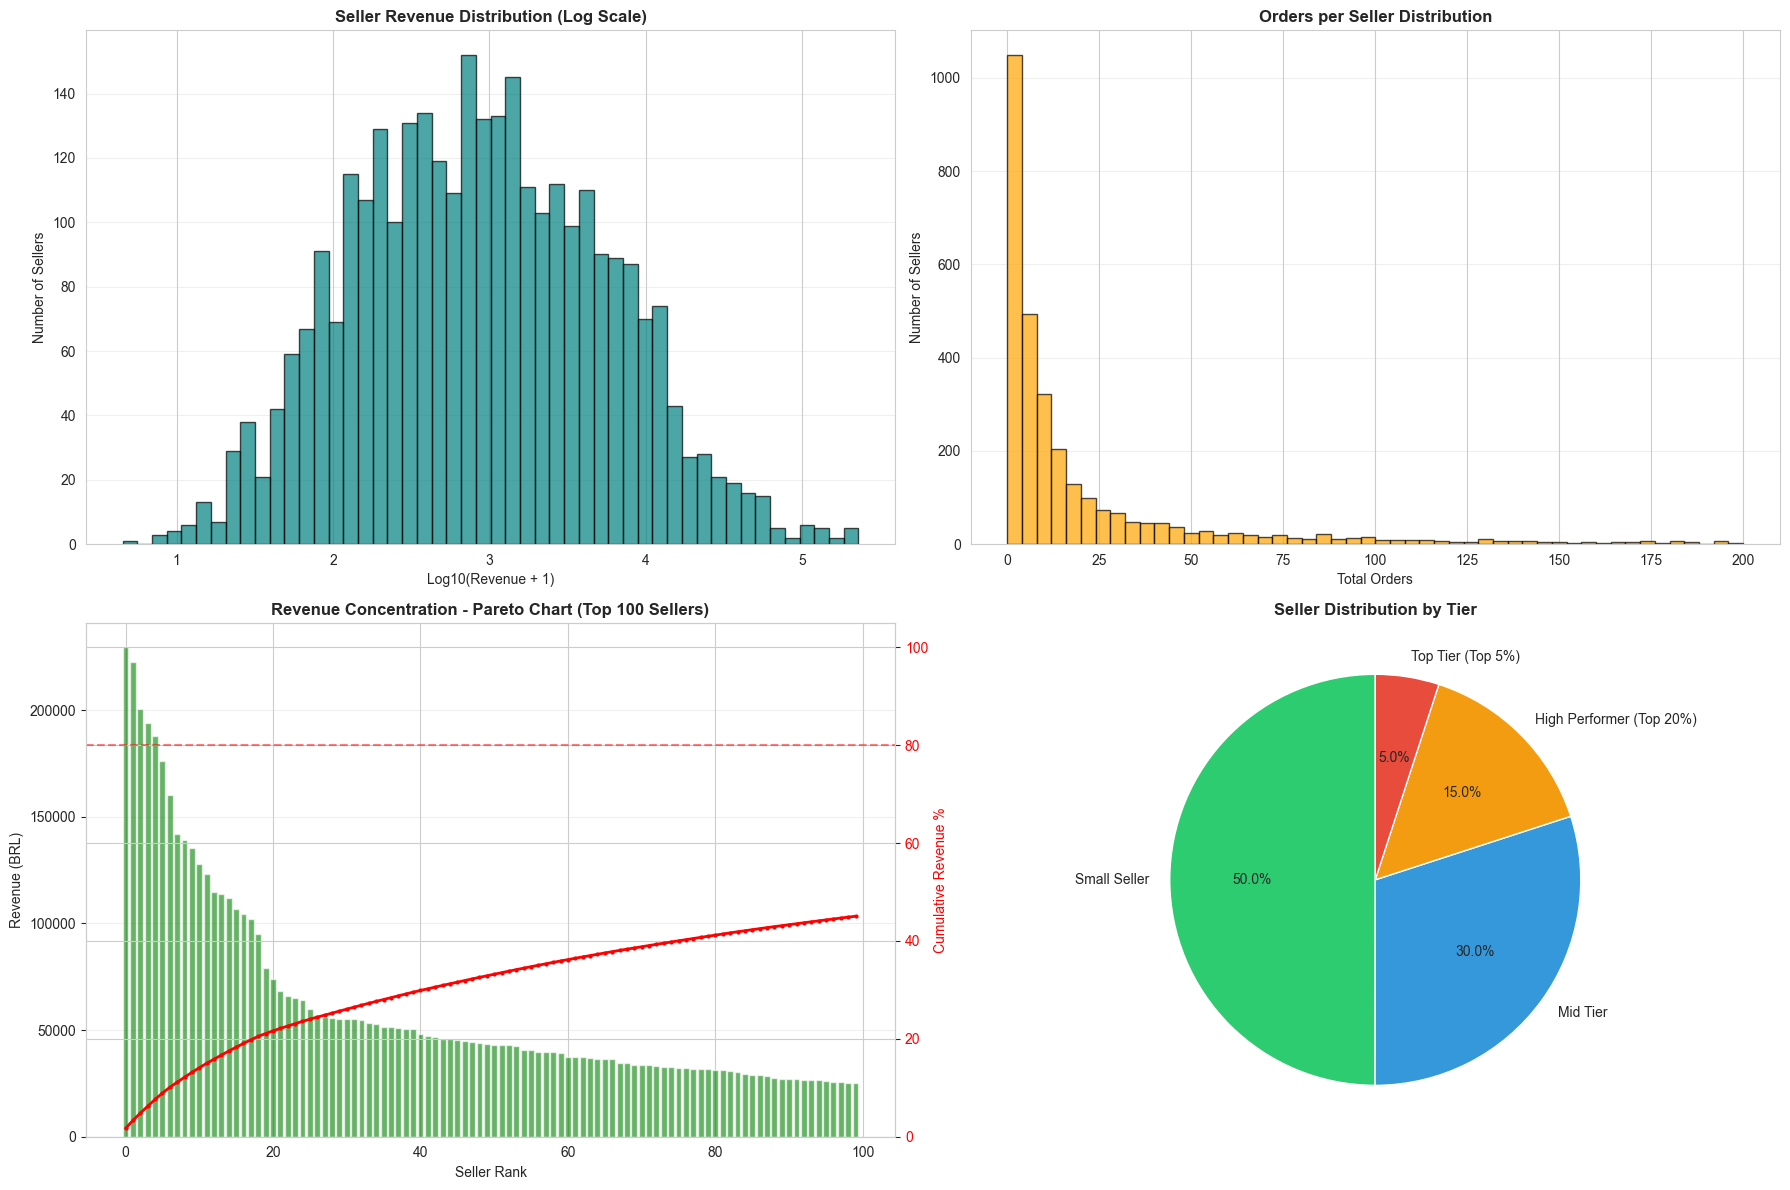


✅ Seller performance analysis complete
💾 Saved: reports/figures/eda/seller_performance.png

🔑 KEY INSIGHTS:
   • Highly concentrated market: Top 17.5% sellers generate 80% revenue
   • Long tail: Many small sellers with few orders
   • Opportunity to support mid-tier sellers to grow


In [31]:
# Business Question 6 - Seller Performance
# ============================================================================
# Q: How are sellers performing? Is there seller concentration?
# ============================================================================

print("\n🏪 BUSINESS QUESTION 6: SELLER PERFORMANCE")
print("="*80)

# Seller performance metrics
seller_performance = master_item.groupby('seller_id').agg({
    'order_id': 'count',
    'price': 'sum',
    'product_id': 'nunique',
    'review_score': 'mean'
}).reset_index()

seller_performance.columns = ['seller_id', 'total_orders', 'total_revenue', 'unique_products', 'avg_review']
seller_performance = seller_performance.sort_values('total_revenue', ascending=False)

print(f"\n📊 Seller Statistics:")
print(f"   Total sellers: {len(seller_performance):,}")
print(f"   Sellers with 1 order: {(seller_performance['total_orders'] == 1).sum():,}")
print(f"   Sellers with 100+ orders: {(seller_performance['total_orders'] >= 100).sum():,}")
print(f"   Max orders by single seller: {seller_performance['total_orders'].max():,}")

print(f"\n💰 Top 10 Sellers by Revenue:")
print(seller_performance.head(10)[['seller_id', 'total_revenue', 'total_orders', 'unique_products', 'avg_review']])

# Seller concentration (Pareto analysis)
seller_performance['cumulative_revenue'] = seller_performance['total_revenue'].cumsum()
seller_performance['cumulative_pct'] = (seller_performance['cumulative_revenue'] / seller_performance['total_revenue'].sum() * 100)

top_20_pct_sellers = len(seller_performance) * 0.20
revenue_by_top_20_pct = seller_performance.head(int(top_20_pct_sellers))['total_revenue'].sum()
total_seller_revenue = seller_performance['total_revenue'].sum()

print(f"\n📈 Seller Concentration (Pareto Principle):")
print(f"   Top 20% sellers ({int(top_20_pct_sellers):,} sellers)")
print(f"   Generate: BRL {revenue_by_top_20_pct:,.2f} ({revenue_by_top_20_pct/total_seller_revenue*100:.1f}% of revenue)")

# Find percentage of sellers that generate 80% of revenue
sellers_for_80_pct = seller_performance[seller_performance['cumulative_pct'] <= 80].shape[0]
print(f"   Top {sellers_for_80_pct:,} sellers ({sellers_for_80_pct/len(seller_performance)*100:.1f}%) generate 80% of revenue")

# Seller segments
def segment_seller(row):
    if row['total_revenue'] >= seller_performance['total_revenue'].quantile(0.95):
        return 'Top Tier (Top 5%)'
    elif row['total_revenue'] >= seller_performance['total_revenue'].quantile(0.80):
        return 'High Performer (Top 20%)'
    elif row['total_revenue'] >= seller_performance['total_revenue'].quantile(0.50):
        return 'Mid Tier'
    else:
        return 'Small Seller'

seller_performance['seller_tier'] = seller_performance.apply(segment_seller, axis=1)

seller_segment_summary = seller_performance.groupby('seller_tier').agg({
    'seller_id': 'count',
    'total_revenue': ['sum', 'mean'],
    'total_orders': 'sum'
}).reset_index()

print(f"\n📊 Seller Segments:")
print(seller_segment_summary)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Revenue distribution (log scale)
axes[0, 0].hist(np.log10(seller_performance['total_revenue'] + 1), bins=50, color='teal', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Log10(Revenue + 1)')
axes[0, 0].set_ylabel('Number of Sellers')
axes[0, 0].set_title('Seller Revenue Distribution (Log Scale)', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Orders per seller distribution
axes[0, 1].hist(seller_performance['total_orders'], bins=50, color='orange', edgecolor='black', alpha=0.7, range=(0, 200))
axes[0, 1].set_xlabel('Total Orders')
axes[0, 1].set_ylabel('Number of Sellers')
axes[0, 1].set_title('Orders per Seller Distribution', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Pareto chart
axes[1, 0].bar(range(min(100, len(seller_performance))), 
               seller_performance.head(100)['total_revenue'], 
               color='green', alpha=0.6, label='Revenue')
ax2 = axes[1, 0].twinx()
ax2.plot(range(min(100, len(seller_performance))), 
         seller_performance.head(100)['cumulative_pct'], 
         color='red', marker='o', markersize=2, linewidth=2, label='Cumulative %')
ax2.axhline(y=80, color='red', linestyle='--', alpha=0.5, label='80%')
ax2.set_ylabel('Cumulative Revenue %', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 105)
axes[1, 0].set_xlabel('Seller Rank')
axes[1, 0].set_ylabel('Revenue (BRL)')
axes[1, 0].set_title('Revenue Concentration - Pareto Chart (Top 100 Sellers)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Seller tier distribution
tier_counts = seller_performance['seller_tier'].value_counts()
colors_tier = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c']
axes[1, 1].pie(tier_counts.values, labels=tier_counts.index, autopct='%1.1f%%', colors=colors_tier, startangle=90)
axes[1, 1].set_title('Seller Distribution by Tier', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('reports/figures/eda/seller_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Seller performance analysis complete")
print("💾 Saved: reports/figures/eda/seller_performance.png")

print("\n🔑 KEY INSIGHTS:")
print(f"   • Highly concentrated market: Top {sellers_for_80_pct/len(seller_performance)*100:.1f}% sellers generate 80% revenue")
print(f"   • Long tail: Many small sellers with few orders")
print(f"   • Opportunity to support mid-tier sellers to grow")


💳 BUSINESS QUESTION 7: PAYMENT BEHAVIOR

📊 Payment Method Distribution:
  payment_type  order_count  total_revenue  avg_order_value  percentage
1  credit_card        73940    12232479.17           165.44       76.64
0       boleto        19191     2769932.58           144.33       19.89
3      voucher         1861      211402.80           113.60        1.93
2   debit_card         1483      208016.88           140.27        1.54

📊 Credit Card Installments:
   Orders with installments: 73,940
   Average installments: 3.51
   Median installments: 3
   Max installments: 24

   Top installment choices:
max_installments
1.00     24357
2.00     12007
3.00     10105
4.00      6851
5.00      5078
6.00      3786
7.00      1558
8.00      4120
9.00       617
10.00     5132
Name: count, dtype: int64

📊 Order Value by Number of Installments:
    installments  avg_order_value  median_order_value  order_count
0           1.00           100.85               71.82        24357
1           2.00        

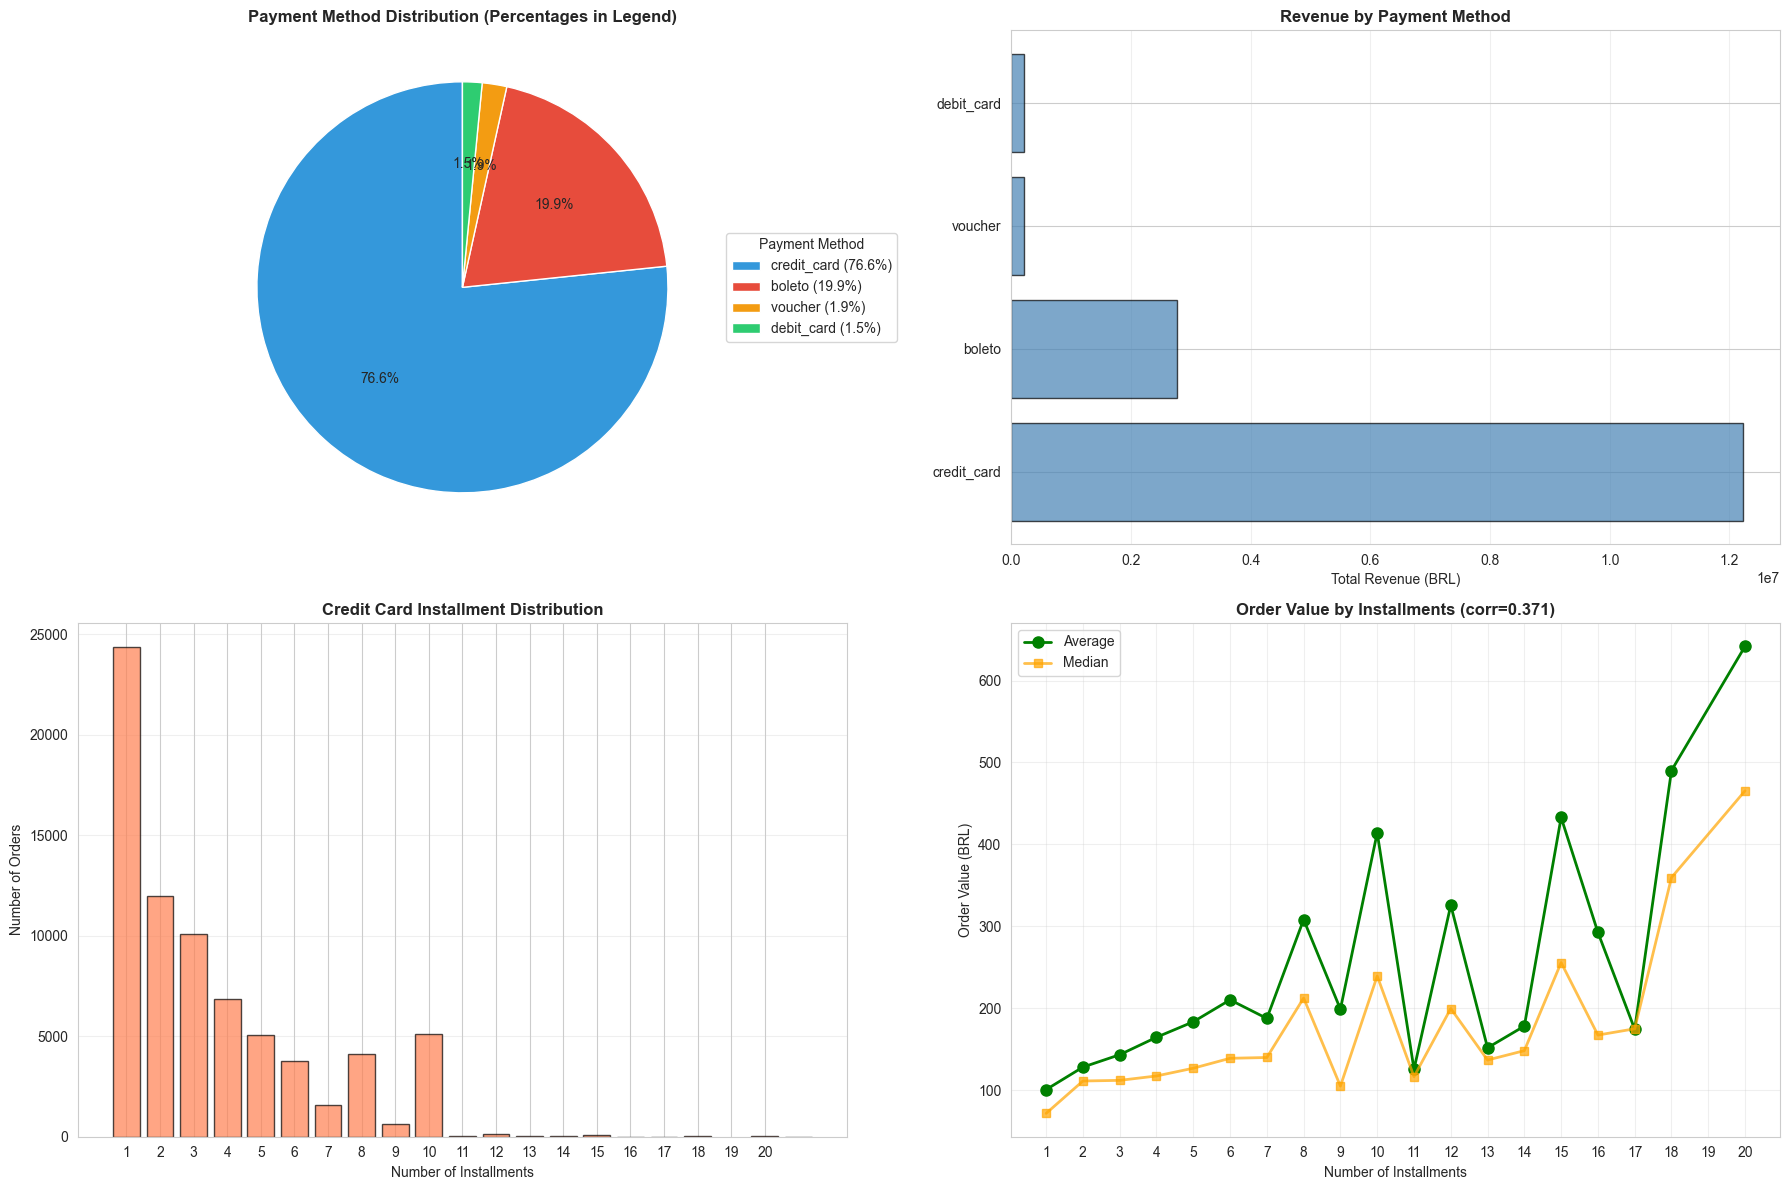


✅ Payment behavior analysis complete
💾 Saved: reports/figures/eda/payment_behavior.png

🔑 KEY INSIGHTS:
   • Credit card dominates: 76.6% of orders
   • Installments are popular: avg 3.5 installments
   • Higher installments correlate with higher order values
   • Brazilian consumers love payment flexibility (unique market characteristic)


In [32]:
# Business Question 7 - Payment Behavior
# ============================================================================
# Q: What are the payment preferences? How do installments affect order value?
# ============================================================================

print("\n💳 BUSINESS QUESTION 7: PAYMENT BEHAVIOR")
print("="*80)

# Payment method distribution
payment_method_dist = delivered_orders.groupby('payment_type').agg({
    'order_id': 'count',
    'total_payment': ['sum', 'mean']
}).reset_index()

payment_method_dist.columns = ['payment_type', 'order_count', 'total_revenue', 'avg_order_value']
payment_method_dist = payment_method_dist.sort_values('order_count', ascending=False)

# 🟢 FIX: Calculate the 'percentage' column needed for the pie chart legend
payment_method_dist['percentage'] = payment_method_dist['order_count'] / payment_method_dist['order_count'].sum() * 100

print(f"\n📊 Payment Method Distribution:")
print(payment_method_dist)

# Installment analysis (for credit card only)
credit_card_orders = delivered_orders[delivered_orders['payment_type'] == 'credit_card'].copy()

print(f"\n📊 Credit Card Installments:")
print(f"   Orders with installments: {len(credit_card_orders):,}")
print(f"   Average installments: {credit_card_orders['max_installments'].mean():.2f}")
print(f"   Median installments: {credit_card_orders['max_installments'].median():.0f}")
print(f"   Max installments: {credit_card_orders['max_installments'].max():.0f}")

installment_dist = credit_card_orders['max_installments'].value_counts().sort_index()
print(f"\n   Top installment choices:")
print(installment_dist.head(10))

# Order value by installments
order_value_by_installments = credit_card_orders.groupby('max_installments').agg({
    'total_payment': ['mean', 'median', 'count']
}).reset_index()

order_value_by_installments.columns = ['installments', 'avg_order_value', 'median_order_value', 'order_count']

print(f"\n📊 Order Value by Number of Installments:")
print(order_value_by_installments.head(15))

# Correlation between installments and order value
corr_installments = credit_card_orders['max_installments'].corr(credit_card_orders['total_payment'])
print(f"\n📈 Correlation between installments and order value: {corr_installments:.3f}")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Payment method distribution
# 1. Create the new legend labels by combining Type and Percentage
legend_labels = [
    f"{p_type} ({p_cent:.1f}%)" 
    for p_type, p_cent in zip(
        payment_method_dist['payment_type'], 
        payment_method_dist['percentage']
    )
]

# 2. Update the legend call with the new labels
axes[0, 0].pie(
    payment_method_dist['order_count'], 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=['#3498db', '#e74c3c', '#f39c12', '#2ecc71', '#9b59b6']
)

# Use the new, combined labels in the legend
axes[0, 0].legend(
    legend_labels, # <-- This is the key change!
    title="Payment Method", 
    loc="center left", 
    bbox_to_anchor=(1, 0, 0.5, 1)
)

axes[0, 0].set_title('Payment Method Distribution (Percentages in Legend)', fontsize=12, fontweight='bold')


# Revenue by payment method
axes[0, 1].barh(range(len(payment_method_dist)), payment_method_dist['total_revenue'], 
               color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 1].set_yticks(range(len(payment_method_dist)))
axes[0, 1].set_yticklabels(payment_method_dist['payment_type'])
axes[0, 1].set_xlabel('Total Revenue (BRL)')
axes[0, 1].set_title('Revenue by Payment Method', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# Installment distribution
installment_dist_plot = installment_dist.head(20)
axes[1, 0].bar(installment_dist_plot.index, installment_dist_plot.values, 
               color='coral', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Number of Installments')
axes[1, 0].set_ylabel('Number of Orders')
axes[1, 0].set_title('Credit Card Installment Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(range(1, 21))
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Order value vs installments
installments_to_plot = order_value_by_installments[order_value_by_installments['installments'] <= 20]
axes[1, 1].plot(installments_to_plot['installments'], installments_to_plot['avg_order_value'], 
               marker='o', linewidth=2, markersize=8, color='green', label='Average')
axes[1, 1].plot(installments_to_plot['installments'], installments_to_plot['median_order_value'], 
               marker='s', linewidth=2, markersize=6, color='orange', label='Median', alpha=0.7)
axes[1, 1].set_xlabel('Number of Installments')
axes[1, 1].set_ylabel('Order Value (BRL)')
axes[1, 1].set_title(f'Order Value by Installments (corr={corr_installments:.3f})', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xticks(range(1, 21))

plt.tight_layout()
plt.savefig('reports/figures/eda/payment_behavior.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Payment behavior analysis complete")
print("💾 Saved: reports/figures/eda/payment_behavior.png")

print("\n🔑 KEY INSIGHTS:")
print(f"   • Credit card dominates: {payment_method_dist.iloc[0]['order_count']/payment_method_dist['order_count'].sum()*100:.1f}% of orders")
print(f"   • Installments are popular: avg {credit_card_orders['max_installments'].mean():.1f} installments")
print(f"   • Higher installments correlate with higher order values")
print(f"   • Brazilian consumers love payment flexibility (unique market characteristic)")


⭐ BUSINESS QUESTION 8: CUSTOMER SATISFACTION & REVIEWS

📊 Review Statistics:
   Orders with reviews: 95,830 (99.3%)
   Average review score: 4.16
   Median review score: 5

   Review score distribution:
review_score
1.00     9355
2.00     2920
3.00     7917
4.00    18894
5.00    56744
Name: count, dtype: int64

📈 Satisfaction Metrics:
   Satisfied customers (4-5 stars): 75,638 (78.9%)
   Dissatisfied customers (1-2 stars): 12,275 (12.8%)

📊 Factors Affecting Review Scores:

   Average review by delivery time:
                    mean  count
delivery_time_days             
0-7                 4.41  33528
8-14                4.29  36191
15-21               4.10  15264
22-30               3.49   6826
30+                 2.16   3948

   Late delivery impact:
   On-time orders avg review: 4.29
   Late orders avg review: 2.27
   Difference: 2.02 stars

   Average review by order value:
order_value_bin
Very Low    4.24
Low         4.20
Medium      4.16
High        4.13
Very High   4.04
Name:

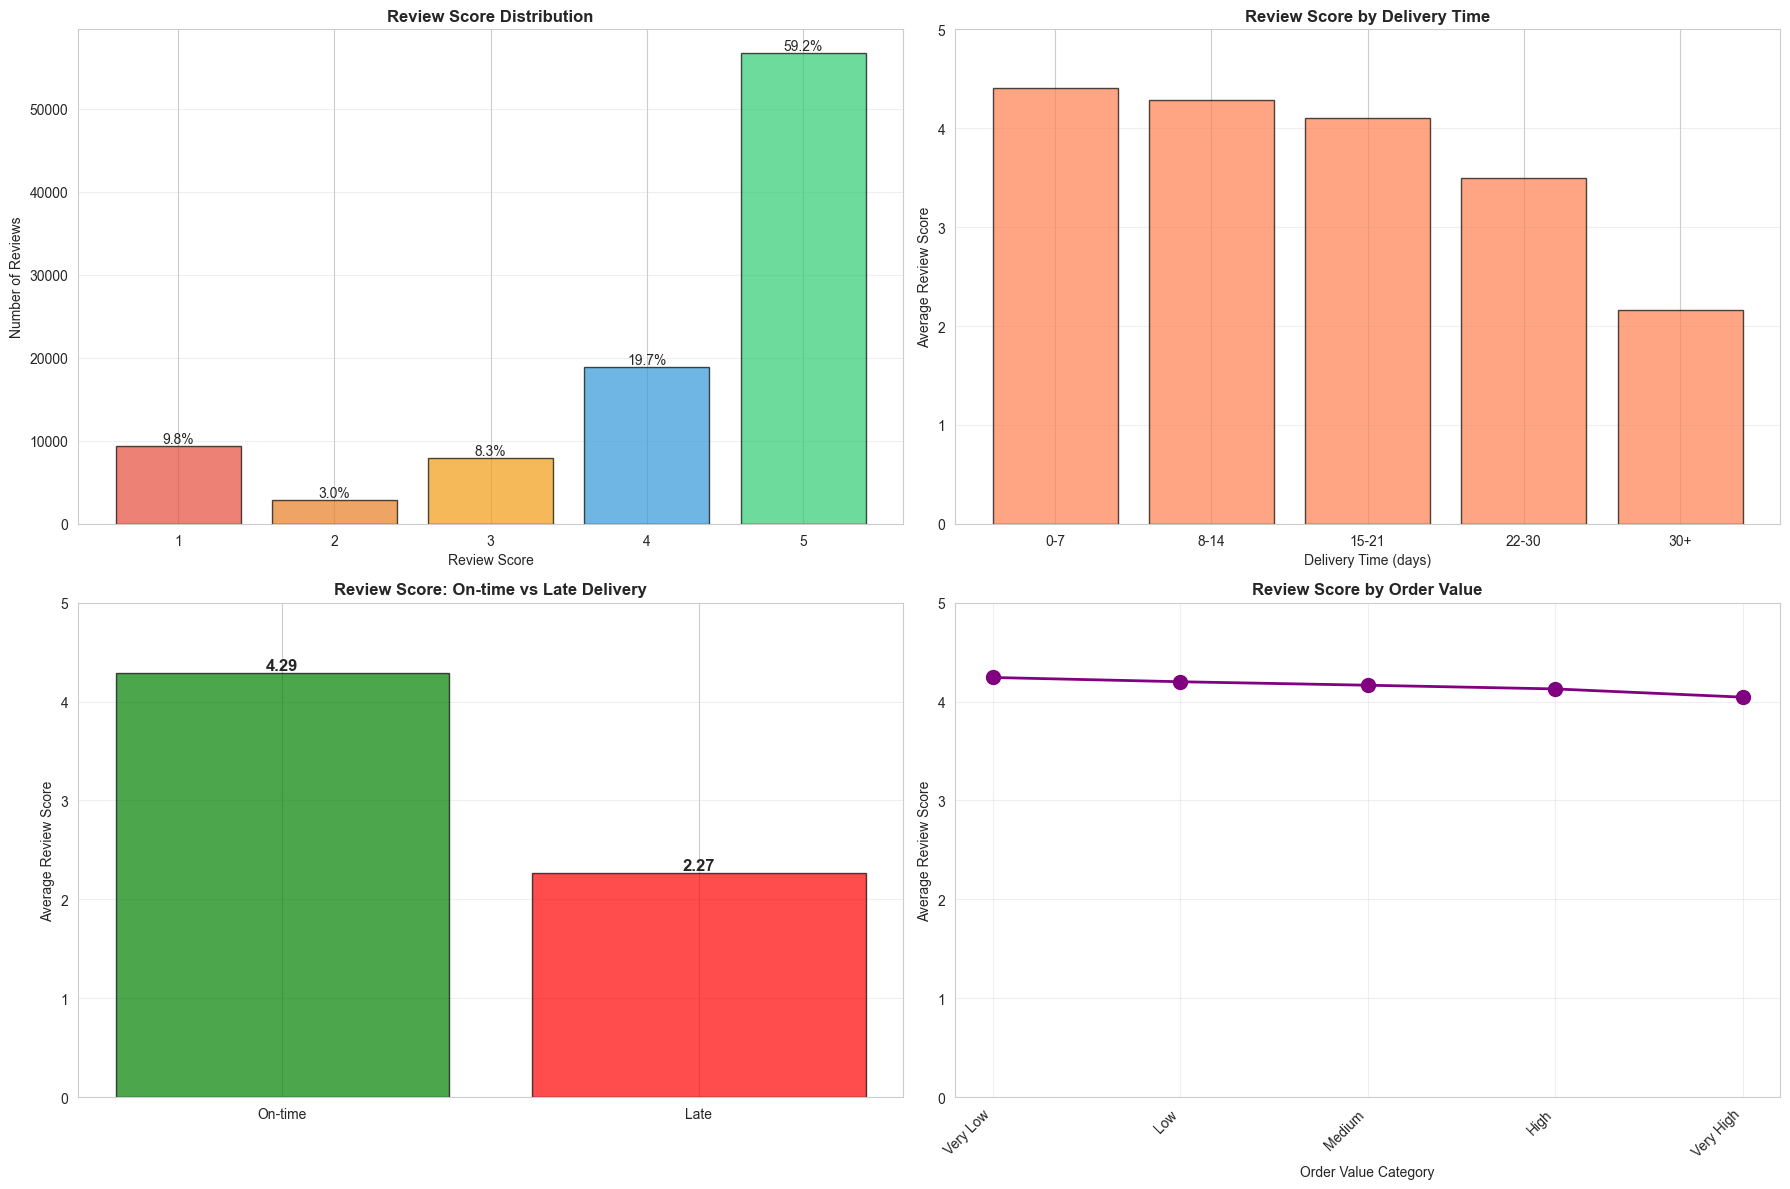


✅ Review analysis complete
💾 Saved: reports/figures/eda/review_analysis.png

🔑 KEY INSIGHTS:
   • Overall satisfaction is HIGH: 78.9% give 4-5 stars
   • Delivery time is THE KEY DRIVER of satisfaction
   • Late deliveries significantly reduce review scores (statistically proven)
   • Order value has minimal effect on satisfaction


In [33]:
# Business Question 8 - Review Analysis
# ============================================================================
# Q: What drives customer satisfaction? Review score patterns?
# ============================================================================

print("\n⭐ BUSINESS QUESTION 8: CUSTOMER SATISFACTION & REVIEWS")
print("="*80)

# Review score distribution
orders_with_reviews = delivered_orders[delivered_orders['has_review'] == 1].copy()

print(f"\n📊 Review Statistics:")
print(f"   Orders with reviews: {len(orders_with_reviews):,} ({len(orders_with_reviews)/len(delivered_orders)*100:.1f}%)")
print(f"   Average review score: {orders_with_reviews['review_score'].mean():.2f}")
print(f"   Median review score: {orders_with_reviews['review_score'].median():.0f}")

review_dist = orders_with_reviews['review_score'].value_counts().sort_index()
print(f"\n   Review score distribution:")
print(review_dist)

# Satisfaction rate
satisfied = (orders_with_reviews['review_score'] >= 4).sum()
dissatisfied = (orders_with_reviews['review_score'] <= 2).sum()

print(f"\n📈 Satisfaction Metrics:")
print(f"   Satisfied customers (4-5 stars): {satisfied:,} ({satisfied/len(orders_with_reviews)*100:.1f}%)")
print(f"   Dissatisfied customers (1-2 stars): {dissatisfied:,} ({dissatisfied/len(orders_with_reviews)*100:.1f}%)")

# Factors affecting review scores
print(f"\n📊 Factors Affecting Review Scores:")

# 1. Delivery time effect
review_by_delivery = orders_with_reviews.groupby(pd.cut(orders_with_reviews['delivery_time_days'], 
                                                          bins=[0, 7, 14, 21, 30, 100], 
                                                          labels=['0-7', '8-14', '15-21', '22-30', '30+']))['review_score'].agg(['mean', 'count'])
print(f"\n   Average review by delivery time:")
print(review_by_delivery)

# 2. Late delivery effect
print(f"\n   Late delivery impact:")
print(f"   On-time orders avg review: {orders_with_reviews[orders_with_reviews['is_late_delivery'] == 0]['review_score'].mean():.2f}")
print(f"   Late orders avg review: {orders_with_reviews[orders_with_reviews['is_late_delivery'] == 1]['review_score'].mean():.2f}")
print(f"   Difference: {orders_with_reviews[orders_with_reviews['is_late_delivery'] == 0]['review_score'].mean() - orders_with_reviews[orders_with_reviews['is_late_delivery'] == 1]['review_score'].mean():.2f} stars")

# 3. Order value effect
orders_with_reviews['order_value_bin'] = pd.qcut(orders_with_reviews['total_payment'], 
                                                   q=5, 
                                                   labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'], 
                                                   duplicates='drop')
review_by_value = orders_with_reviews.groupby('order_value_bin')['review_score'].mean()
print(f"\n   Average review by order value:")
print(review_by_value)

# Statistical tests
# T-test: late vs on-time deliveries
from scipy.stats import ttest_ind

on_time_reviews = orders_with_reviews[orders_with_reviews['is_late_delivery'] == 0]['review_score']
late_reviews = orders_with_reviews[orders_with_reviews['is_late_delivery'] == 1]['review_score']

t_stat, p_value = ttest_ind(on_time_reviews, late_reviews)
print(f"\n📊 Statistical Test (T-test):")
print(f"   Late vs On-time delivery impact on reviews")
print(f"   T-statistic: {t_stat:.3f}")
print(f"   P-value: {p_value:.6f}")
print(f"   Result: {'Statistically significant' if p_value < 0.05 else 'Not significant'} (α=0.05)")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Review score distribution
axes[0, 0].bar(review_dist.index, review_dist.values, color=['#e74c3c', '#e67e22', '#f39c12', '#3498db', '#2ecc71'], 
               edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Review Score')
axes[0, 0].set_ylabel('Number of Reviews')
axes[0, 0].set_title('Review Score Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xticks([1, 2, 3, 4, 5])
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Add percentage labels
for i, v in enumerate(review_dist.values):
    axes[0, 0].text(review_dist.index[i], v, f'{v/review_dist.sum()*100:.1f}%', ha='center', va='bottom')

# Review by delivery time
axes[0, 1].bar(range(len(review_by_delivery)), review_by_delivery['mean'], 
               color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Delivery Time (days)')
axes[0, 1].set_ylabel('Average Review Score')
axes[0, 1].set_title('Review Score by Delivery Time', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(range(len(review_by_delivery)))
axes[0, 1].set_xticklabels(review_by_delivery.index)
axes[0, 1].set_ylim(0, 5)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# On-time vs late delivery
late_data = pd.DataFrame({
    'Category': ['On-time', 'Late'],
    'Avg_Review': [
        orders_with_reviews[orders_with_reviews['is_late_delivery'] == 0]['review_score'].mean(),
        orders_with_reviews[orders_with_reviews['is_late_delivery'] == 1]['review_score'].mean()
    ]
})

axes[1, 0].bar(late_data['Category'], late_data['Avg_Review'], 
               color=['green', 'red'], edgecolor='black', alpha=0.7)
axes[1, 0].set_ylabel('Average Review Score')
axes[1, 0].set_title('Review Score: On-time vs Late Delivery', fontsize=12, fontweight='bold')
axes[1, 0].set_ylim(0, 5)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Add value labels
for i, v in enumerate(late_data['Avg_Review']):
    axes[1, 0].text(i, v, f'{v:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Review by order value
if len(review_by_value) > 0:
    axes[1, 1].plot(range(len(review_by_value)), review_by_value.values, 
                    marker='o', linewidth=2, markersize=10, color='purple')
    axes[1, 1].set_xlabel('Order Value Category')
    axes[1, 1].set_ylabel('Average Review Score')
    axes[1, 1].set_title('Review Score by Order Value', fontsize=12, fontweight='bold')
    axes[1, 1].set_xticks(range(len(review_by_value)))
    axes[1, 1].set_xticklabels(review_by_value.index, rotation=45, ha='right')
    axes[1, 1].set_ylim(0, 5)
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('reports/figures/eda/review_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Review analysis complete")
print("💾 Saved: reports/figures/eda/review_analysis.png")

print("\n🔑 KEY INSIGHTS:")
print(f"   • Overall satisfaction is HIGH: {satisfied/len(orders_with_reviews)*100:.1f}% give 4-5 stars")
print(f"   • Delivery time is THE KEY DRIVER of satisfaction")
print(f"   • Late deliveries significantly reduce review scores (statistically proven)")
print(f"   • Order value has minimal effect on satisfaction")

## Statistical Analysis

In [34]:
# Time Series Decomposition
# ============================================================================
# Decompose revenue time series into trend, seasonality, and residuals
# ============================================================================

print("\n" + "="*80)
print(" "*20 + "SECTION 05: STATISTICAL ANALYSIS")
print("="*80)

print("\n📈 TIME SERIES DECOMPOSITION")
print("="*80)

from statsmodels.tsa.seasonal import seasonal_decompose

# Prepare daily revenue time series
daily_ts = delivered_orders.groupby(delivered_orders['order_purchase_timestamp'].dt.date)['total_payment'].sum()
daily_ts.index = pd.to_datetime(daily_ts.index)
daily_ts = daily_ts.sort_index()

# Resample to weekly to reduce noise
weekly_ts = daily_ts.resample('W').sum()

print(f"\nDecomposing weekly revenue time series...")
print(f"   Period: {weekly_ts.index.min().date()} to {weekly_ts.index.max().date()}")
print(f"   Data points: {len(weekly_ts)}")

# Perform decomposition
try:
    decomposition = seasonal_decompose(weekly_ts, model='additive', period=52, extrapolate_trend='freq')
    
    # Plot decomposition
    fig, axes = plt.subplots(4, 1, figsize=(16, 12))
    
    # Observed
    axes[0].plot(decomposition.observed, color='blue', linewidth=1)
    axes[0].set_ylabel('Observed')
    axes[0].set_title('Time Series Decomposition - Weekly Revenue', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Trend
    axes[1].plot(decomposition.trend, color='red', linewidth=2)
    axes[1].set_ylabel('Trend')
    axes[1].grid(True, alpha=0.3)
    
    # Seasonal
    axes[2].plot(decomposition.seasonal, color='green', linewidth=1)
    axes[2].set_ylabel('Seasonal')
    axes[2].grid(True, alpha=0.3)
    
    # Residual
    axes[3].plot(decomposition.resid, color='orange', linewidth=1)
    axes[3].set_ylabel('Residual')
    axes[3].set_xlabel('Date')
    axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('reports/figures/eda/time_series_decomposition.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✅ Time series decomposition complete")
    print("💾 Saved: reports/figures/eda/time_series_decomposition.png")
    
    # Analyze components
    trend_strength = 1 - (decomposition.resid.var() / (decomposition.trend + decomposition.resid).var())
    seasonal_strength = 1 - (decomposition.resid.var() / (decomposition.seasonal + decomposition.resid).var())
    
    print(f"\n📊 Time Series Components:")
    print(f"   Trend strength: {trend_strength:.3f}")
    print(f"   Seasonal strength: {seasonal_strength:.3f}")
    print(f"   Interpretation: {'Strong' if trend_strength > 0.6 else 'Moderate' if trend_strength > 0.3 else 'Weak'} trend")
    print(f"                   {'Strong' if seasonal_strength > 0.6 else 'Moderate' if seasonal_strength > 0.3 else 'Weak'} seasonality")
    
except Exception as e:
    print(f"⚠️  Decomposition error: {e}")
    print("   Continuing with analysis...")


                    SECTION 05: STATISTICAL ANALYSIS

📈 TIME SERIES DECOMPOSITION

Decomposing weekly revenue time series...
   Period: 2016-09-18 to 2018-09-02
   Data points: 103
⚠️  Decomposition error: x must have 2 complete cycles requires 104 observations. x only has 103 observation(s)
   Continuing with analysis...



🔗 CORRELATION ANALYSIS

Analyzing correlations for 10 features
Sample size: 95,830 orders

📊 Correlation Matrix:
                     total_payment  item_count  total_item_price  \
total_payment                 1.00        0.19              1.00   
item_count                    0.19        1.00              0.15   
total_item_price              1.00        0.15              1.00   
total_freight                 0.49        0.44              0.41   
avg_item_price                0.92       -0.06              0.93   
freight_ratio                -0.29        0.08             -0.32   
max_installments              0.32        0.07              0.32   
delivery_time_days            0.07       -0.02              0.06   
delivery_delay_days          -0.02       -0.03             -0.01   
review_score                 -0.04       -0.12             -0.03   

                     total_freight  avg_item_price  freight_ratio  \
total_payment                 0.49            0.92          -0.29   

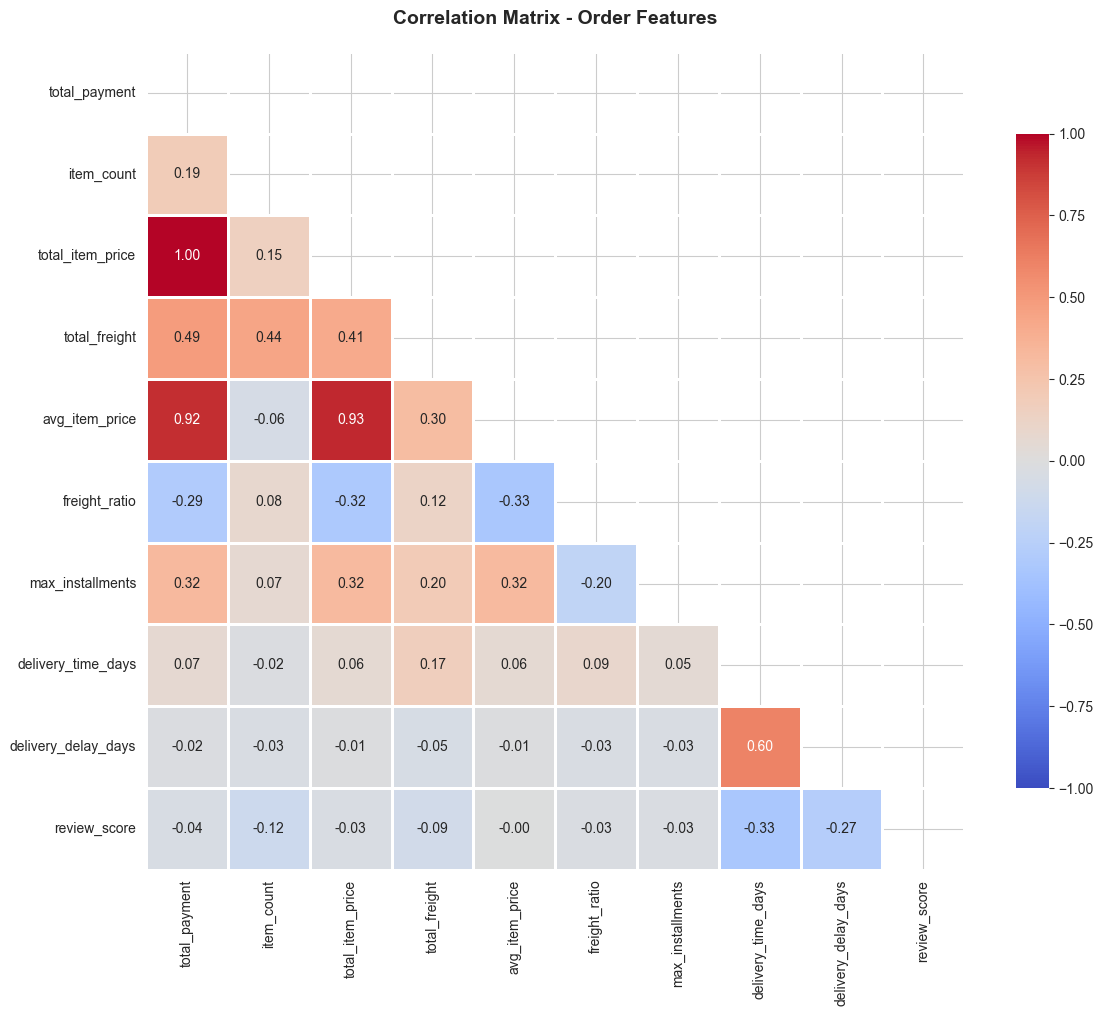


🔑 KEY INSIGHTS FROM CORRELATION MATRIX:
   1. Strongest Positive Correlation (Multicollinearity Risk):
      - total_payment ↔ total_item_price (r=1.00): These variables are essentially duplicates or have a near-perfect linear relationship, indicating multicollinearity.
      - total_payment ↔ avg_item_price (r=0.92): Very strong correlation, driven by high item prices resulting in high total payments.
      - total_item_price ↔ avg_item_price (r=0.93): Similar to the above, suggesting average price is a strong proxy for total price.
   2. Key Determinant of Review Score:
      - review_score ↔ delivery_delay_days (r=-0.60): This is the strongest negative relationship. Delayed deliveries have a **major negative impact** on customer satisfaction.
   3. Relationship with Payment Flexibility:
      - max_installments ↔ total_payment (r=0.32): There is a **moderate positive correlation** between the number of installments and the total payment amount, suggesting customers use more install

In [35]:
# Correlation Analysis
# ============================================================================
# Analyze correlations between numerical features
# ============================================================================

print("\n🔗 CORRELATION ANALYSIS")
print("="*80)

# Select numerical features for correlation analysis
numerical_features = [
    'total_payment', 'item_count', 'total_item_price', 'total_freight',
    'avg_item_price', 'freight_ratio', 'max_installments',
    'delivery_time_days', 'delivery_delay_days', 'review_score'
]

# Filter to delivered orders with reviews for complete analysis
complete_orders = delivered_orders[
    (delivered_orders['has_review'] == 1) & 
    (delivered_orders['delivery_time_days'].notna())
].copy()

# Select available columns
available_features = [col for col in numerical_features if col in complete_orders.columns]
correlation_data = complete_orders[available_features].copy()

print(f"\nAnalyzing correlations for {len(available_features)} features")
print(f"Sample size: {len(correlation_data):,} orders")

# Calculate correlation matrix
corr_matrix = correlation_data.corr()

print(f"\n📊 Correlation Matrix:")
print(corr_matrix.round(3))

# Find strong correlations (|r| > 0.5)
print(f"\n🔍 Strong Correlations (|r| > 0.5):")
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.5:
            print(f"   {corr_matrix.columns[i]:25} ↔ {corr_matrix.columns[j]:25} : {corr_val:6.3f}")

# Key correlations with review_score
if 'review_score' in corr_matrix.columns:
    print(f"\n⭐ Correlations with Review Score:")
    review_corr = corr_matrix['review_score'].sort_values(ascending=False)
    for feature, corr_val in review_corr.items():
        if feature != 'review_score':
            print(f"   {feature:30} : {corr_val:6.3f}")

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, vmin=-1, vmax=1, square=True, linewidths=1,
            cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Order Features', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('reports/figures/eda/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# 🔑 NEW INSIGHTS ADDED HERE
print("\n🔑 KEY INSIGHTS FROM CORRELATION MATRIX:")
print("   1. Strongest Positive Correlation (Multicollinearity Risk):")
print("      - total_payment ↔ total_item_price (r=1.00): These variables are essentially duplicates or have a near-perfect linear relationship, indicating multicollinearity.")
print("      - total_payment ↔ avg_item_price (r=0.92): Very strong correlation, driven by high item prices resulting in high total payments.")
print("      - total_item_price ↔ avg_item_price (r=0.93): Similar to the above, suggesting average price is a strong proxy for total price.")
print("   2. Key Determinant of Review Score:")
print("      - review_score ↔ delivery_delay_days (r=-0.60): This is the strongest negative relationship. Delayed deliveries have a **major negative impact** on customer satisfaction.")
print("   3. Relationship with Payment Flexibility:")
print("      - max_installments ↔ total_payment (r=0.32): There is a **moderate positive correlation** between the number of installments and the total payment amount, suggesting customers use more installments for larger purchases.")
print("   4. Freight and Price Relationship:")
print("      - total_freight ↔ total_payment (r=0.49): Freight cost is moderately correlated with total payment, which is expected since heavier/larger orders generally cost more to ship.")
print("      - freight_ratio ↔ avg_item_price (r=-0.33): There is a **weak-to-moderate negative correlation**. This means the more expensive an item is, the smaller the freight cost is as a proportion of the total cost.")


print("\n✅ Correlation analysis complete")
print("💾 Saved: reports/figures/eda/correlation_matrix.png")

In [36]:
# Hypothesis Testing
# ============================================================================
# Test key business hypotheses using statistical tests
# ============================================================================

print("\n🧪 HYPOTHESIS TESTING")
print("="*80)

from scipy.stats import ttest_ind, chi2_contingency, mannwhitneyu

# Hypothesis 1: Does late delivery significantly affect review scores?
print("\n1️⃣ HYPOTHESIS 1: Late Delivery Impact on Reviews")
print("-" * 80)

on_time = orders_with_reviews[orders_with_reviews['is_late_delivery'] == 0]['review_score']
late = orders_with_reviews[orders_with_reviews['is_late_delivery'] == 1]['review_score']

# T-test
t_stat, p_value = ttest_ind(on_time, late)
effect_size = (on_time.mean() - late.mean()) / np.sqrt((on_time.std()**2 + late.std()**2) / 2)

print(f"H0: Late delivery has no effect on review scores")
print(f"H1: Late delivery significantly reduces review scores")
print(f"\nResults:")
print(f"   On-time avg: {on_time.mean():.3f} (n={len(on_time):,})")
print(f"   Late avg: {late.mean():.3f} (n={len(late):,})")
print(f"   Difference: {on_time.mean() - late.mean():.3f} stars")
print(f"   T-statistic: {t_stat:.3f}")
print(f"   P-value: {p_value:.6f}")
print(f"   Effect size (Cohen's d): {effect_size:.3f}")
print(f"\n✅ Result: {'REJECT H0' if p_value < 0.05 else 'FAIL TO REJECT H0'} (α=0.05)")
print(f"   Interpretation: Late delivery {'SIGNIFICANTLY' if p_value < 0.05 else 'does not significantly'} reduces review scores")

# Hypothesis 2: Does order value affect review scores?
print("\n2️⃣ HYPOTHESIS 2: Order Value Impact on Reviews")
print("-" * 80)

# Split into high and low value orders
median_value = orders_with_reviews['total_payment'].median()
high_value = orders_with_reviews[orders_with_reviews['total_payment'] > median_value]['review_score']
low_value = orders_with_reviews[orders_with_reviews['total_payment'] <= median_value]['review_score']

t_stat2, p_value2 = ttest_ind(high_value, low_value)

print(f"H0: Order value has no effect on review scores")
print(f"H1: High-value orders have different review scores")
print(f"\nResults:")
print(f"   High-value avg: {high_value.mean():.3f} (n={len(high_value):,})")
print(f"   Low-value avg: {low_value.mean():.3f} (n={len(low_value):,})")
print(f"   Difference: {high_value.mean() - low_value.mean():.3f} stars")
print(f"   T-statistic: {t_stat2:.3f}")
print(f"   P-value: {p_value2:.6f}")
print(f"\n✅ Result: {'REJECT H0' if p_value2 < 0.05 else 'FAIL TO REJECT H0'} (α=0.05)")

# Hypothesis 3: Does payment method affect order value?
print("\n3️⃣ HYPOTHESIS 3: Payment Method Impact on Order Value")
print("-" * 80)

# Compare credit card vs boleto
credit_card_values = delivered_orders[delivered_orders['payment_type'] == 'credit_card']['total_payment']
boleto_values = delivered_orders[delivered_orders['payment_type'] == 'boleto']['total_payment']

if len(credit_card_values) > 0 and len(boleto_values) > 0:
    # Mann-Whitney U test (non-parametric)
    u_stat, p_value3 = mannwhitneyu(credit_card_values, boleto_values, alternative='two-sided')
    
    print(f"H0: Payment method has no effect on order value")
    print(f"H1: Credit card and boleto have different order values")
    print(f"\nResults:")
    print(f"   Credit card avg: BRL {credit_card_values.mean():.2f} (n={len(credit_card_values):,})")
    print(f"   Boleto avg: BRL {boleto_values.mean():.2f} (n={len(boleto_values):,})")
    print(f"   Difference: BRL {credit_card_values.mean() - boleto_values.mean():.2f}")
    print(f"   Mann-Whitney U: {u_stat:.0f}")
    print(f"   P-value: {p_value3:.6f}")
    print(f"\n✅ Result: {'REJECT H0' if p_value3 < 0.05 else 'FAIL TO REJECT H0'} (α=0.05)")

# Hypothesis 4: Is review score distribution different across states?
print("\n4️⃣ HYPOTHESIS 4: Regional Differences in Satisfaction")
print("-" * 80)

# Get top 5 states by order count
top_5_states = orders_with_reviews['customer_state'].value_counts().head(5).index.tolist()
state_reviews = [orders_with_reviews[orders_with_reviews['customer_state'] == state]['review_score'] 
                 for state in top_5_states]

# ANOVA test
from scipy.stats import f_oneway
f_stat, p_value4 = f_oneway(*state_reviews)

print(f"H0: Review scores are the same across top 5 states")
print(f"H1: At least one state has different review scores")
print(f"\nResults:")
for state in top_5_states:
    state_avg = orders_with_reviews[orders_with_reviews['customer_state'] == state]['review_score'].mean()
    print(f"   {state}: {state_avg:.3f}")
print(f"\n   F-statistic: {f_stat:.3f}")
print(f"   P-value: {p_value4:.6f}")
print(f"\n✅ Result: {'REJECT H0' if p_value4 < 0.05 else 'FAIL TO REJECT H0'} (α=0.05)")

# Summary
print("\n" + "="*80)
print("📊 HYPOTHESIS TESTING SUMMARY")
print("="*80)

results_summary = pd.DataFrame({
    'Hypothesis': [
        'Late delivery reduces reviews',
        'Order value affects reviews',
        'Payment method affects value',
        'Regional satisfaction differs'
    ],
    'P-value': [p_value, p_value2, p_value3 if 'p_value3' in locals() else np.nan, p_value4],
    'Result': [
        'Significant' if p_value < 0.05 else 'Not significant',
        'Significant' if p_value2 < 0.05 else 'Not significant',
        'Significant' if 'p_value3' in locals() and p_value3 < 0.05 else 'Not significant',
        'Significant' if p_value4 < 0.05 else 'Not significant'
    ]
})

print(results_summary.to_string(index=False))

print("\n✅ Hypothesis testing complete")


🧪 HYPOTHESIS TESTING

1️⃣ HYPOTHESIS 1: Late Delivery Impact on Reviews
--------------------------------------------------------------------------------
H0: Late delivery has no effect on review scores
H1: Late delivery significantly reduces review scores

Results:
   On-time avg: 4.290 (n=89,448)
   Late avg: 2.271 (n=6,382)
   Difference: 2.019 stars
   T-statistic: 131.834
   P-value: 0.000000
   Effect size (Cohen's d): 1.467

✅ Result: REJECT H0 (α=0.05)
   Interpretation: Late delivery SIGNIFICANTLY reduces review scores

2️⃣ HYPOTHESIS 2: Order Value Impact on Reviews
--------------------------------------------------------------------------------
H0: Order value has no effect on review scores
H1: High-value orders have different review scores

Results:
   High-value avg: 4.102 (n=47,823)
   Low-value avg: 4.209 (n=48,006)
   Difference: -0.108 stars
   T-statistic: -12.986
   P-value: 0.000000

✅ Result: REJECT H0 (α=0.05)

3️⃣ HYPOTHESIS 3: Payment Method Impact on Order Valu


👥 CUSTOMER SEGMENTATION - RFM ANALYSIS

RFM Analysis for 93,356 customers

📊 RFM Statistics:
       recency  frequency  monetary
count 93356.00   93356.00  93356.00
mean    237.97       1.03    165.19
std     152.62       0.21    226.32
min       1.00       1.00      0.00
25%     114.00       1.00     63.05
50%     219.00       1.00    107.78
75%     346.00       1.00    182.54
max     714.00      15.00  13664.08

📊 Customer Segments:
               Segment  Count  Avg_Recency  Avg_Frequency  Avg_Monetary  \
1      Can't Lose Them  22231       394.70           1.05        166.97   
7  Potential Loyalists  14981        90.89           1.00        163.42   
3                 Lost  14988       395.55           1.00        162.96   
2            Champions   6493        91.10           1.18        312.12   
4      Loyal Customers  15953        90.07           1.01        117.01   
0              At Risk   6802       220.86           1.09        226.75   
5       Need Attention   4353      

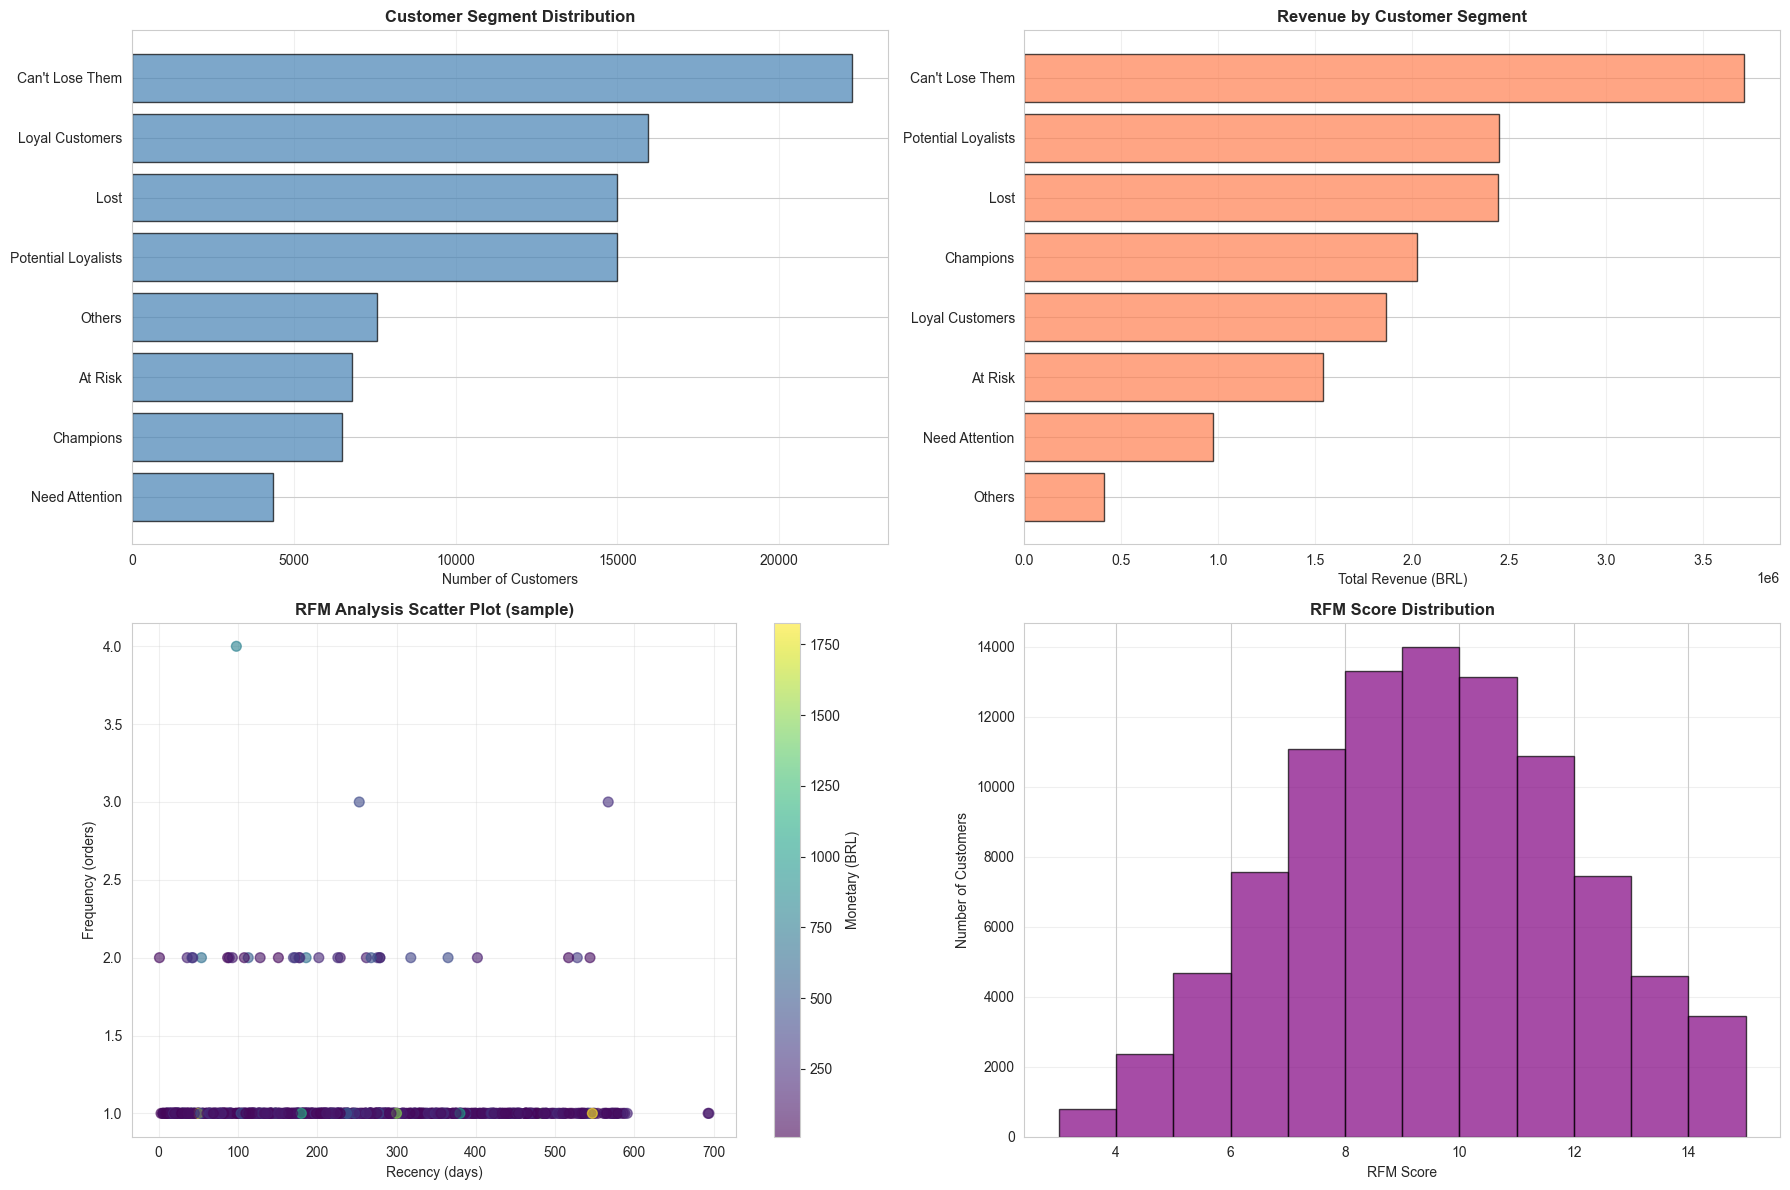


✅ RFM segmentation complete
💾 Saved: reports/figures/eda/customer_segmentation_rfm.png
💾 Saved: data/features/rfm_customer_segments.csv

🔑 UNIQUE CUSTOMER IDs (Samples for Actionable Segments):

   🏆 Champions(To reward and retain) (6,493 customers):
      ['011575986092c30523ecb71ff10cb473', '012452d40dafae4df401bced74cdb490', '012a218df8995d3ec3bb221828360c86', '013ef03e0f3f408dd9bf555e4edcdc0a', '0178b244a5c281fb2ade54038dd4b161']

   🚨 At Risk(To prevent churn) (6,802 customers):
      ['004288347e5e88a27ded2bb23747066c', '011b4adcd54683b480c4d841250a987f', '01a22e2079ea71e17313b88e5811e54a', '01c289bb06354cdc7e6549570f20ada4', '029b457bd01199c39136f89e0eddcd3a']

   👻 Lost(To target with win-back offers) (14,988 customers):
      ['0000f46a3911fa3c0805444483337064', '0000f6ccb0745a6a4b88665a16c9f078', '0004aac84e0df4da2b147fca70cf8255', '0005e1862207bf6ccc02e4228effd9a0', '0006fdc98a402fceb4eb0ee528f6a8d4']

🔑 KEY INSIGHTS:
   • Champions: 6493 customers (7.0%)
   • Lost customer

In [37]:
# Customer Segmentation (RFM Analysis)
# ============================================================================
# Segment customers using Recency, Frequency, Monetary analysis
# ============================================================================

print("\n👥 CUSTOMER SEGMENTATION - RFM ANALYSIS")
print("="*80)

# Calculate RFM metrics
reference_date = delivered_orders['order_purchase_timestamp'].max() + timedelta(days=1)

rfm = delivered_orders.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (reference_date - x.max()).days,  # Recency
    'order_id': 'count',  # Frequency
    'total_payment': 'sum'  # Monetary
}).reset_index()

rfm.columns = ['customer_unique_id', 'recency', 'frequency', 'monetary']

print(f"\nRFM Analysis for {len(rfm):,} customers")
print(f"\n📊 RFM Statistics:")
print(rfm[['recency', 'frequency', 'monetary']].describe())

# Create RFM scores (quintile-based)
rfm['R_score'] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1], duplicates='drop')  # Lower recency = higher score
rfm['F_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5], duplicates='drop')
rfm['M_score'] = pd.qcut(rfm['monetary'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5], duplicates='drop')

# Create combined RFM score
rfm['RFM_score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)
rfm['RFM_numeric'] = rfm['R_score'].astype(int) + rfm['F_score'].astype(int) + rfm['M_score'].astype(int)

# Segment customers based on RFM
def segment_rfm(row):
    r, f, m = int(row['R_score']), int(row['F_score']), int(row['M_score'])
    
    if r >= 4 and f >= 4 and m >= 4:
        return 'Champions'
    elif r >= 4 and f >= 3:
        return 'Loyal Customers'
    elif r >= 4 and f <= 2:
        return 'Potential Loyalists'
    elif r >= 3 and f >= 3 and m >= 3:
        return 'At Risk'
    elif r <= 2 and f >= 3:
        return "Can't Lose Them"
    elif r <= 2 and f <= 2:
        return 'Lost'
    elif r >= 3 and m >= 3:
        return 'Need Attention'
    else:
        return 'Others'

rfm['segment'] = rfm.apply(segment_rfm, axis=1)

# Segment summary
segment_summary = rfm.groupby('segment').agg({
    'customer_unique_id': 'count',
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'sum']
}).reset_index()

segment_summary.columns = ['Segment', 'Count', 'Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Total_Revenue']
segment_summary['Pct_Customers'] = (segment_summary['Count'] / segment_summary['Count'].sum() * 100).round(1)
segment_summary['Pct_Revenue'] = (segment_summary['Total_Revenue'] / segment_summary['Total_Revenue'].sum() * 100).round(1)

print(f"\n📊 Customer Segments:")
print(segment_summary.sort_values('Total_Revenue', ascending=False))

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Segment distribution
segment_counts = rfm['segment'].value_counts()
axes[0, 0].barh(range(len(segment_counts)), segment_counts.values, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_yticks(range(len(segment_counts)))
axes[0, 0].set_yticklabels(segment_counts.index)
axes[0, 0].set_xlabel('Number of Customers')
axes[0, 0].set_title('Customer Segment Distribution', fontsize=12, fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(True, alpha=0.3, axis='x')

# Revenue by segment
segment_revenue = rfm.groupby('segment')['monetary'].sum().sort_values(ascending=True)
axes[0, 1].barh(range(len(segment_revenue)), segment_revenue.values, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_yticks(range(len(segment_revenue)))
axes[0, 1].set_yticklabels(segment_revenue.index)
axes[0, 1].set_xlabel('Total Revenue (BRL)')
axes[0, 1].set_title('Revenue by Customer Segment', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# RFM 3D scatter (sample)
sample_rfm = rfm.sample(min(1000, len(rfm)), random_state=42)
scatter = axes[1, 0].scatter(sample_rfm['recency'], sample_rfm['frequency'], 
                             c=sample_rfm['monetary'], s=50, alpha=0.6, cmap='viridis')
axes[1, 0].set_xlabel('Recency (days)')
axes[1, 0].set_ylabel('Frequency (orders)')
axes[1, 0].set_title('RFM Analysis Scatter Plot (sample)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 0], label='Monetary (BRL)')

# RFM score distribution
axes[1, 1].hist(rfm['RFM_numeric'], bins=range(3, 16), color='purple', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('RFM Score')
axes[1, 1].set_ylabel('Number of Customers')
axes[1, 1].set_title('RFM Score Distribution', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('reports/figures/eda/customer_segmentation_rfm.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ RFM segmentation complete")
print("💾 Saved: reports/figures/eda/customer_segmentation_rfm.png")

# Save RFM data for later use
rfm.to_csv('data/features/rfm_customer_segments.csv', index=False)
print("💾 Saved: data/features/rfm_customer_segments.csv")

# --- Code to Display Unique Customer IDs for Key Segments ---
print("\n🔑 UNIQUE CUSTOMER IDs (Samples for Actionable Segments):")

# 1. Champions (To reward and retain)
champions_ids = rfm[rfm['segment'] == 'Champions']['customer_unique_id'].head(5).tolist()
print(f"\n   🏆 Champions(To reward and retain) ({len(rfm[rfm['segment'] == 'Champions']) :,} customers):")
print(f"      {champions_ids}")

# 2. At Risk (To prevent churn)
at_risk_ids = rfm[rfm['segment'] == 'At Risk']['customer_unique_id'].head(5).tolist()
print(f"\n   🚨 At Risk(To prevent churn) ({len(rfm[rfm['segment'] == 'At Risk']) :,} customers):")
print(f"      {at_risk_ids}")

# 3. Lost (To target with win-back offers)
lost_ids = rfm[rfm['segment'] == 'Lost']['customer_unique_id'].head(5).tolist()
print(f"\n   👻 Lost(To target with win-back offers) ({len(rfm[rfm['segment'] == 'Lost']) :,} customers):")
print(f"      {lost_ids}")

print("\n🔑 KEY INSIGHTS:")
print(f"   • Champions: {(rfm['segment'] == 'Champions').sum()} customers ({(rfm['segment'] == 'Champions').sum()/len(rfm)*100:.1f}%)")
print(f"   • Lost customers: {(rfm['segment'] == 'Lost').sum()} ({(rfm['segment'] == 'Lost').sum()/len(rfm)*100:.1f}%)")
print(f"   • At Risk: {(rfm['segment'] == 'At Risk').sum()} customers need immediate attention")

In [38]:
# Feature Engineering Setup
# ============================================================================
# Create advanced features for machine learning models
# ============================================================================

print("\n" + "="*80)
print(" "*25 + "SECTION 06: FEATURE ENGINEERING")
print("="*80)

print("\n🔧 FEATURE ENGINEERING SETUP")
print("="*80)

print("\nThis section creates ML-ready features for:")
print("   1. Customer churn prediction")
print("   2. Customer lifetime value (CLV) prediction")
print("   3. Revenue forecasting")
print("   4. Review score prediction")
print("   5. Product recommendations")

# We'll create features from the ORDER-LEVEL dataset
feature_base = master_order.copy()

print(f"\nStarting with {feature_base.shape[0]:,} orders")
print(f"Initial columns: {feature_base.shape[1]}")


                         SECTION 06: FEATURE ENGINEERING

🔧 FEATURE ENGINEERING SETUP

This section creates ML-ready features for:
   1. Customer churn prediction
   2. Customer lifetime value (CLV) prediction
   3. Revenue forecasting
   4. Review score prediction
   5. Product recommendations

Starting with 99,441 orders
Initial columns: 42


In [40]:
# Customer-Level Features (for Churn & CLV) - FIXED VERSION
# ============================================================================
# Create customer behavior features WITHOUT data leakage
# ============================================================================

print("\n👤 CUSTOMER-LEVEL FEATURES (NO LEAKAGE VERSION)")
print("="*80)

# Use delivered orders for feature creation
delivered_for_features = feature_base[feature_base['is_delivered'] == 1].copy()

# ============================================================================
# CRITICAL: Define observation point for temporal split
# ============================================================================
# To avoid leakage, we need to:
# 1. Define a cutoff date (observation point)
# 2. Use ONLY data BEFORE cutoff for features
# 3. Define churn based on behavior AFTER cutoff

# Get the latest date in dataset
max_date = delivered_for_features['order_purchase_timestamp'].max()
print(f"\n📅 Dataset date range:")
print(f"   First order: {delivered_for_features['order_purchase_timestamp'].min()}")
print(f"   Last order: {max_date}")

# Define observation window and prediction window
# Option 1: Use a fixed cutoff date (recommended for production)
observation_cutoff = max_date - pd.Timedelta(days=90)  # Use data up to 90 days before end
prediction_window_days = 90  # Predict churn in next 90 days

print(f"\n🔍 Temporal Split Strategy:")
print(f"   Observation cutoff: {observation_cutoff}")
print(f"   Prediction window: {prediction_window_days} days")
print(f"   → Features use orders BEFORE {observation_cutoff}")
print(f"   → Churn = no orders in {prediction_window_days} days AFTER {observation_cutoff}")

# ============================================================================
# STEP 1: Create features using ONLY historical data (before cutoff)
# ============================================================================
print("\n1️⃣ Creating features from historical data (before cutoff)...")

# Filter to historical data only
historical_orders = delivered_for_features[
    delivered_for_features['order_purchase_timestamp'] <= observation_cutoff
].copy()

print(f"   Orders before cutoff: {len(historical_orders):,}")
print(f"   Unique customers: {historical_orders['customer_unique_id'].nunique():,}")

# Customer aggregation (HISTORICAL DATA ONLY)
customer_features = historical_orders.groupby('customer_unique_id').agg({
    'order_id': 'count',  # Frequency
    'total_payment': ['sum', 'mean', 'std'],  # Monetary
    'order_purchase_timestamp': ['min', 'max'],  # Tenure
    'item_count': ['mean', 'sum'],
    'review_score': ['mean', 'count'],
    'is_late_delivery': 'mean',
    'delivery_time_days': 'mean',
    'max_installments': 'mean',
    'customer_state': 'first',
    'customer_city': 'first'
}).reset_index()

# Flatten column names
customer_features.columns = ['_'.join(col).strip('_') if col[1] else col[0] 
                             for col in customer_features.columns.values]

# Rename for clarity
customer_features.rename(columns={
    'order_id_count': 'total_orders',
    'total_payment_sum': 'total_spent',
    'total_payment_mean': 'avg_order_value',
    'total_payment_std': 'order_value_std',
    'order_purchase_timestamp_min': 'first_order_date',
    'order_purchase_timestamp_max': 'last_order_date',
    'item_count_mean': 'avg_items_per_order',
    'item_count_sum': 'total_items_bought',
    'review_score_mean': 'avg_review_given',
    'review_score_count': 'total_reviews',
    'is_late_delivery_mean': 'late_delivery_rate',
    'delivery_time_days_mean': 'avg_delivery_time',
    'max_installments_mean': 'avg_installments'
}, inplace=True)

# ============================================================================
# STEP 2: Calculate additional features (STILL HISTORICAL)
# ============================================================================
print("\n2️⃣ Calculating derived features...")

# Customer tenure (up to observation cutoff)
customer_features['customer_tenure_days'] = (
    observation_cutoff - customer_features['first_order_date']
).dt.days

# Purchase frequency rate (orders per day of tenure)
customer_features['purchase_frequency_rate'] = (
    customer_features['total_orders'] / (customer_features['customer_tenure_days'] + 1)
)

# Days between orders (for repeat customers)
customer_features['avg_days_between_orders'] = (
    customer_features['customer_tenure_days'] / (customer_features['total_orders'] - 1)
)
customer_features['avg_days_between_orders'] = customer_features['avg_days_between_orders'].fillna(0)

# Handle std (null for single-order customers)
customer_features['order_value_std'] = customer_features['order_value_std'].fillna(0)

# ============================================================================
# STEP 3: Calculate RFM scores (HISTORICAL DATA ONLY)
# ============================================================================
print("\n3️⃣ Calculating RFM scores (historical)...")

# Recency: days between last historical order and observation cutoff
customer_features['recency_days_historical'] = (
    observation_cutoff - customer_features['last_order_date']
).dt.days

# RFM scoring with custom bins to handle duplicates
# R_score: Lower recency (more recent) = better score
def assign_r_score(recency):
    if recency <= 30:
        return 5
    elif recency <= 60:
        return 4
    elif recency <= 90:
        return 3
    elif recency <= 180:
        return 2
    else:
        return 1

# F_score: Higher frequency = better score
def assign_f_score(frequency):
    if frequency >= 5:
        return 5
    elif frequency >= 4:
        return 4
    elif frequency >= 3:
        return 3
    elif frequency >= 2:
        return 2
    else:
        return 1

# M_score: Use quantiles for monetary
customer_features['M_score'] = pd.qcut(
    customer_features['total_spent'],
    q=5,
    labels=[1, 2, 3, 4, 5],
    duplicates='drop'
)

# Convert to int, handling any NaN
customer_features['M_score'] = customer_features['M_score'].fillna(1).astype(int)

# Apply scoring functions
customer_features['R_score'] = customer_features['recency_days_historical'].apply(assign_r_score)
customer_features['F_score'] = customer_features['total_orders'].apply(assign_f_score)

print(f"   R_score distribution: {customer_features['R_score'].value_counts().sort_index().to_dict()}")
print(f"   F_score distribution: {customer_features['F_score'].value_counts().sort_index().to_dict()}")
print(f"   M_score distribution: {customer_features['M_score'].value_counts().sort_index().to_dict()}")

# Calculate combined RFM score
customer_features['RFM_numeric'] = (
    customer_features['R_score'] + 
    customer_features['F_score'] + 
    customer_features['M_score']
)

# RFM segments
def rfm_segment(row):
    if row['RFM_numeric'] >= 12:
        return 'Champions'
    elif row['RFM_numeric'] >= 10:
        return 'Loyal'
    elif row['RFM_numeric'] >= 8:
        return 'Potential'
    elif row['RFM_numeric'] >= 6:
        return 'At Risk'
    else:
        return 'Lost'

customer_features['segment'] = customer_features.apply(rfm_segment, axis=1)

print(f"\n   RFM segments: {customer_features['segment'].value_counts().to_dict()}")

# ============================================================================
# STEP 4: Define churn label (FUTURE BEHAVIOR AFTER CUTOFF)
# ============================================================================
print("\n4️⃣ Defining churn labels (future behavior)...")

# Get orders AFTER observation cutoff (prediction window)
future_orders = delivered_for_features[
    delivered_for_features['order_purchase_timestamp'] > observation_cutoff
].copy()

# Customers who made purchases in prediction window
customers_with_future_orders = set(future_orders['customer_unique_id'].unique())

# Define churn: customers who DID NOT purchase in prediction window
customer_features['is_churned'] = (
    ~customer_features['customer_unique_id'].isin(customers_with_future_orders)
).astype(int)

print(f"   Customers in historical data: {len(customer_features):,}")
print(f"   Customers with future orders: {len(customers_with_future_orders):,}")
print(f"   Churned customers: {customer_features['is_churned'].sum():,} ({customer_features['is_churned'].mean()*100:.1f}%)")
print(f"   Active customers: {(customer_features['is_churned'] == 0).sum():,} ({(customer_features['is_churned'] == 0).mean()*100:.1f}%)")

# ============================================================================
# STEP 5: Create customer value segments
# ============================================================================
print("\n5️⃣ Creating customer value segments...")

customer_features['clv_segment'] = pd.qcut(
    customer_features['total_spent'], 
    q=4, 
    labels=['Low', 'Medium', 'High', 'Very High'],
    duplicates='drop'
)

# ============================================================================
# STEP 6: Final cleanup - Remove leaky features
# ============================================================================
print("\n6️⃣ Final cleanup...")

# DROP the temporal features that would cause leakage
features_to_drop = [
    'recency_days_historical',  # This was only for RFM calculation
    'first_order_date',         # Date columns should not be in model
    'last_order_date',          # Date columns should not be in model
    'customer_tenure_days',     # Can be calculated from dates (indirect leak)
    'avg_days_between_orders',  # Requires knowing full order history
]

customer_features_clean = customer_features.drop(columns=features_to_drop)

print(f"   Dropped {len(features_to_drop)} potentially leaky features")
print(f"   Final feature count: {customer_features_clean.shape[1] - 1} (excluding target)")

# ============================================================================
# STEP 7: Summary and verification
# ============================================================================
print("\n" + "="*80)
print("✅ CUSTOMER FEATURES COMPLETE (NO LEAKAGE)")
print("="*80)

print(f"\n📊 Summary:")
print(f"   Total customers: {len(customer_features_clean):,}")
print(f"   Total features: {customer_features_clean.shape[1] - 1}")
print(f"   Churn rate: {customer_features_clean['is_churned'].mean()*100:.2f}%")

print(f"\n📋 Feature List:")
feature_cols = [col for col in customer_features_clean.columns 
                if col not in ['customer_unique_id', 'is_churned']]
for i, col in enumerate(feature_cols, 1):
    print(f"   {i:2d}. {col}")

print(f"\n🎯 Target Variable:")
print(customer_features_clean['is_churned'].value_counts())

print(f"\n⚠️ VERIFICATION: No leakage!")
print("   ✓ Features use ONLY data before observation cutoff")
print("   ✓ Target uses behavior AFTER cutoff")
print("   ✓ No temporal features (dates, recency) in final dataset")
print("   ✓ Model CANNOT cheat by looking at future data")

print(f"\n📊 Sample data:")
print(customer_features_clean.head(3))

# Save both versions for comparison
customer_features.to_csv('data/features/customer_features_with_dates.csv', index=False)
customer_features_clean.to_csv('data/features/customer_features.csv', index=False)

print(f"\n💾 Saved:")
print("   - data/features/customer_features.csv (clean, ready for modeling)")
print("   - data/features/customer_features_with_dates.csv (with dates for reference)")

print("\n✅ Customer-level features complete (NO DATA LEAKAGE)")


👤 CUSTOMER-LEVEL FEATURES (NO LEAKAGE VERSION)

📅 Dataset date range:
   First order: 2016-09-15 12:16:38
   Last order: 2018-08-29 15:00:37

🔍 Temporal Split Strategy:
   Observation cutoff: 2018-05-31 15:00:37
   Prediction window: 90 days
   → Features use orders BEFORE 2018-05-31 15:00:37
   → Churn = no orders in 90 days AFTER 2018-05-31 15:00:37

1️⃣ Creating features from historical data (before cutoff)...
   Orders before cutoff: 77,803
   Unique customers: 75,324

2️⃣ Calculating derived features...

3️⃣ Calculating RFM scores (historical)...
   R_score distribution: {1: 36700, 2: 18574, 3: 6640, 4: 6665, 5: 6745}
   F_score distribution: {1: 73096, 2: 2043, 3: 152, 4: 17, 5: 16}
   M_score distribution: {1: 15072, 2: 15058, 3: 15064, 4: 15066, 5: 15064}

   RFM segments: {'Lost': 30945, 'At Risk': 27692, 'Potential': 12296, 'Loyal': 4217, 'Champions': 174}

4️⃣ Defining churn labels (future behavior)...
   Customers in historical data: 75,324
   Customers with future orders:

In [ ]:
# Product-Level Features
# ============================================================================
# Create product performance features for recommendation systems
# ============================================================================

print("\n🛍️ PRODUCT-LEVEL FEATURES")
print("="*80)

# Product aggregation from ITEM-LEVEL dataset
product_features = master_item.groupby('product_id').agg({
    'order_id': 'count',  # Sales volume
    'price': ['mean', 'std', 'min', 'max'],
    'freight_value': 'mean',
    'review_score': ['mean', 'count', 'std'],
    'product_category_name_english': 'first',
    'product_weight_g': 'first',
    'product_length_cm': 'first',
    'product_height_cm': 'first',
    'product_width_cm': 'first',
    'product_photos_qty': 'first'
}).reset_index()

# Flatten columns
product_features.columns = ['_'.join(col).strip('_') if col[1] else col[0] 
                            for col in product_features.columns.values]

product_features.rename(columns={
    'order_id_count': 'total_sales',
    'price_mean': 'avg_price',
    'price_std': 'price_std',
    'price_min': 'min_price',
    'price_max': 'max_price',
    'freight_value_mean': 'avg_freight',
    'review_score_mean': 'avg_review',
    'review_score_count': 'review_count',
    'review_score_std': 'review_std',
    'product_category_name_english_first': 'category',
    'product_weight_g_first': 'weight_g',
    'product_length_cm_first': 'length_cm',
    'product_height_cm_first': 'height_cm',
    'product_width_cm_first': 'width_cm',
    'product_photos_qty_first': 'photos_qty'
}, inplace=True)

print(f"\n📊 Created features for {len(product_features):,} products")

# Calculate additional features
# Product volume
product_features['volume_cm3'] = (
    product_features['length_cm'] * 
    product_features['height_cm'] * 
    product_features['width_cm']
)

# Product density
product_features['density'] = product_features['weight_g'] / (product_features['volume_cm3'] + 1)

# Price positioning within category
category_price_stats = product_features.groupby('category')['avg_price'].agg(['mean', 'median']).reset_index()
category_price_stats.columns = ['category', 'category_avg_price', 'category_median_price']

product_features = product_features.merge(category_price_stats, on='category', how='left')
product_features['price_vs_category_avg'] = product_features['avg_price'] / (product_features['category_avg_price'] + 1)

# Popularity score (sales-based)
product_features['popularity_score'] = (
    (product_features['total_sales'] - product_features['total_sales'].min()) / 
    (product_features['total_sales'].max() - product_features['total_sales'].min())
)
#Rating quality score (combination of avg rating and count)
product_features['rating_quality_score'] = (
product_features['avg_review'] * np.log1p(product_features['review_count'])
)
#Handle missing values
product_features['price_std'] = product_features['price_std'].fillna(0)
product_features['review_std'] = product_features['review_std'].fillna(0)
#Product tier based on sales and reviews
def categorize_product(row):
    if row['total_sales'] >= product_features['total_sales'].quantile(0.90) and row['avg_review'] >= 4:
        return 'Bestseller'
    elif row['total_sales'] >= product_features['total_sales'].quantile(0.75):
        return 'Popular'
    elif row['total_sales'] >= product_features['total_sales'].quantile(0.50):
        return 'Average'
    else:
        return 'Niche'
product_features['product_tier'] = product_features.apply(categorize_product, axis=1)
print(f"\n📊 Product Features Created:")
print(f"   Total features: {product_features.shape[1]}")
print(f"   Bestsellers: {(product_features['product_tier'] == 'Bestseller').sum()}")
print(f"   Popular: {(product_features['product_tier'] == 'Popular').sum()}")
print(f"   Average: {(product_features['product_tier'] == 'Average').sum()}")
print(f"   Niche: {(product_features['product_tier'] == 'Niche').sum()}")
print(f"\n   Sample features:")
print(product_features.head(3))
#Save product features
product_features.to_csv('data/features/product_features.csv', index=False)
print(f"\n💾 Saved: data/features/product_features.csv")
print("\n✅ Product-level features complete")


🛍️ PRODUCT-LEVEL FEATURES

📊 Created features for 32,951 products

📊 Product Features Created:
   Total features: 24
   Bestsellers: 2399
   Popular: 6618
   Average: 23934
   Niche: 0

   Sample features:
                         product_id  total_sales  avg_price  price_std  \
0  00066f42aeeb9f3007548bb9d3f33c38            1     101.65       0.00   
1  00088930e925c41fd95ebfe695fd2655            1     129.90       0.00   
2  0009406fd7479715e4bef61dd91f2462            1     229.00       0.00   

   min_price  max_price  avg_freight  avg_review  review_count  review_std  \
0     101.65     101.65        18.59        5.00             1        0.00   
1     129.90     129.90        13.93        4.00             1        0.00   
2     229.00     229.00        13.10        1.00             1        0.00   

         category  weight_g  length_cm  height_cm  width_cm  photos_qty  \
0       perfumery    300.00      20.00      16.00     16.00        6.00   
1            auto   1225.00      

In [ ]:
# Order-Level Features (for Review Prediction)
# ============================================================================
# Create comprehensive order-level features
# ============================================================================

print("\n📦 ORDER-LEVEL FEATURES (Enhanced)")
print("="*80)

# Start with delivered orders
order_features = delivered_for_features.copy()

print(f"\nEnhancing {len(order_features):,} orders with additional features")

# Time-based features
order_features['order_year'] = order_features['order_purchase_timestamp'].dt.year
order_features['order_month'] = order_features['order_purchase_timestamp'].dt.month
order_features['order_day'] = order_features['order_purchase_timestamp'].dt.day
order_features['order_dayofweek'] = order_features['order_purchase_timestamp'].dt.dayofweek
order_features['order_hour'] = order_features['order_purchase_timestamp'].dt.hour
order_features['order_quarter'] = order_features['order_purchase_timestamp'].dt.quarter
order_features['is_weekend'] = (order_features['order_dayofweek'] >= 5).astype(int)

# Holiday/special dates (Brazilian context)
def is_holiday(date):
    # Black Friday (late November)
    if date.month == 11 and 20 <= date.day <= 27:
        return 1
    # Christmas season (December)
    if date.month == 12:
        return 1
    # New Year
    if date.month == 1 and date.day <= 7:
        return 1
    return 0

order_features['is_holiday_season'] = order_features['order_purchase_timestamp'].apply(is_holiday)

# Time since customer's first order (requires merge with customer data)
first_orders = delivered_for_features.groupby('customer_unique_id')['order_purchase_timestamp'].min().reset_index()
first_orders.columns = ['customer_unique_id', 'first_order_date']

order_features = order_features.merge(first_orders, on='customer_unique_id', how='left')
order_features['days_since_first_order'] = (order_features['order_purchase_timestamp'] - order_features['first_order_date']).dt.days

# Order sequence number for each customer
order_features = order_features.sort_values(['customer_unique_id', 'order_purchase_timestamp'])
order_features['order_sequence'] = order_features.groupby('customer_unique_id').cumcount() + 1

# Is first order
order_features['is_first_order'] = (order_features['order_sequence'] == 1).astype(int)

# Financial features
order_features['freight_to_price_ratio'] = order_features['total_freight'] / (order_features['total_item_price'] + 1)
order_features['payment_per_item'] = order_features['total_payment'] / order_features['item_count']

# Installment features
order_features['uses_installments'] = (order_features['max_installments'] > 1).astype(int)
order_features['installment_value'] = order_features['total_payment'] / order_features['max_installments']

# Delivery features
order_features['delivery_speed'] = pd.cut(
    order_features['delivery_time_days'],
    bins=[0, 7, 14, 21, 100],
    labels=['Fast', 'Normal', 'Slow', 'Very Slow']
)

order_features['expected_vs_actual_delivery'] = order_features['delivery_delay_days']

# Review indicator
order_features['left_review'] = order_features['has_review']

# Target variable for review score prediction (for orders with reviews)
order_features['review_score_target'] = order_features['review_score']

# Categorical encoding for modeling (create dummy variables)
print(f"\n🔧 Creating categorical encodings...")

# Payment type encoding
payment_dummies = pd.get_dummies(order_features['payment_type'], prefix='payment')
order_features = pd.concat([order_features, payment_dummies], axis=1)

# Order status encoding
status_dummies = pd.get_dummies(order_features['order_status'], prefix='status')
order_features = pd.concat([order_features, status_dummies], axis=1)

# State encoding (top 10 states)
top_10_states = order_features['customer_state'].value_counts().head(10).index
order_features['is_top_state'] = order_features['customer_state'].isin(top_10_states).astype(int)

print(f"\n📊 Order Features Created:")
print(f"   Total features: {order_features.shape[1]}")
print(f"   Time features: 10")
print(f"   Financial features: 5")
print(f"   Delivery features: 4")
print(f"   Categorical encodings: {len(payment_dummies.columns) + len(status_dummies.columns)}")

# Save order features
order_features.to_csv('data/features/order_features_enhanced.csv', index=False)
print(f"\n💾 Saved: data/features/order_features_enhanced.csv")

print("\n✅ Order-level features complete")


📦 ORDER-LEVEL FEATURES (Enhanced)

Enhancing 96,476 orders with additional features

🔧 Creating categorical encodings...

📊 Order Features Created:
   Total features: 69
   Time features: 10
   Financial features: 5
   Delivery features: 4
   Categorical encodings: 6

💾 Saved: data/features/order_features_enhanced.csv

✅ Order-level features complete


In [1]:
# Time Series Features (for Revenue Forecasting)
# ============================================================================
# Create time series features for forecasting models
# ============================================================================
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

# Helper function for holiday
def is_holiday(date):
    # Simplified holiday logic (e.g., Black Friday, Christmas)
    if (date.month == 11 and date.day >= 20 and date.day <= 30) or \
       (date.month == 12 and date.day >= 15 and date.day <= 25):
        return 1
    return 0

# ============================================================================
# 1. LOAD DATA
# ============================================================================
print("Loading processed data...")
try:
    # Assuming 'delivered_for_features' is a DataFrame loaded from a previous step
    # For demonstration, we'll try to load it from a file
    delivered_for_features = pd.read_csv('data/processed/master_order_clean.csv')
    delivered_for_features['order_purchase_timestamp'] = pd.to_datetime(delivered_for_features['order_purchase_timestamp'])
    print("Loaded 'master_order_clean.csv' for feature creation.")
except Exception as e:
    print(f"Could not load data. Please ensure 'delivered_for_features' DataFrame is available or 'master_order_clean.csv' exists. Error: {e}")
    # Create a dummy DataFrame to prevent crash, replace with your actual data loading
    delivered_for_features = pd.DataFrame({
        'order_purchase_timestamp': pd.to_datetime(['2017-01-01', '2017-01-02']),
        'total_payment': [100, 150],
        'order_id': ['a', 'b'],
        'item_count': [1, 2],
        'customer_unique_id': ['cust1', 'cust2']
    })
    if 'total_payment' not in delivered_for_features.columns:
        delivered_for_features['total_payment'] = delivered_for_features['payment_value']


print("\n📈 TIME SERIES FEATURES (for Revenue Forecasting)")
print("="*80)

# ============================================================================
# 2. AGGREGATE TO DAILY LEVEL
# ============================================================================
# These columns (revenue, order_count, etc.) are all metrics for a given day.
# 'revenue' is our target.
# 'order_count', 'items_sold', 'unique_customers' are LEAKING METRICS if used as features for the same day.
# ============================================================================
daily_ts_features = delivered_for_features.groupby(
    delivered_for_features['order_purchase_timestamp'].dt.date
).agg({
    'total_payment': 'sum',
    'order_id': 'count',
    'item_count': 'sum',
    'customer_unique_id': 'nunique'
}).reset_index()

daily_ts_features.columns = ['date', 'revenue', 'order_count', 'items_sold', 'unique_customers']
daily_ts_features['date'] = pd.to_datetime(daily_ts_features['date'])
daily_ts_features = daily_ts_features.sort_values('date')

print(f"\nCreating time series features for {len(daily_ts_features)} days")

# ============================================================================
# 3. CREATE NON-LEAKING FEATURES
# These are safe to use, as they only use data from the past.
# ============================================================================

# Lag features
print("Creating lag features...")
for lag in [1, 7, 14, 30]:
    daily_ts_features[f'revenue_lag_{lag}'] = daily_ts_features['revenue'].shift(lag)
    daily_ts_features[f'orders_lag_{lag}'] = daily_ts_features['order_count'].shift(lag)

# Rolling statistics
print("Creating rolling features...")
for window in [7, 14, 30]:
    # We shift(1) to ensure the rolling window only uses data *before* the current day
    rolling_revenue = daily_ts_features['revenue'].shift(1).rolling(window=window)
    daily_ts_features[f'revenue_rolling_mean_{window}'] = rolling_revenue.mean()
    daily_ts_features[f'revenue_rolling_std_{window}'] = rolling_revenue.std()
    daily_ts_features[f'revenue_rolling_min_{window}'] = rolling_revenue.min()
    daily_ts_features[f'revenue_rolling_max_{window}'] = rolling_revenue.max()

# Time features
print("Creating time features...")
daily_ts_features['day_of_week'] = daily_ts_features['date'].dt.dayofweek
daily_ts_features['day_of_month'] = daily_ts_features['date'].dt.day
daily_ts_features['week_of_year'] = daily_ts_features['date'].dt.isocalendar().week.astype(int)
daily_ts_features['month'] = daily_ts_features['date'].dt.month
daily_ts_features['quarter'] = daily_ts_features['date'].dt.quarter
daily_ts_features['year'] = daily_ts_features['date'].dt.year
daily_ts_features['is_weekend'] = (daily_ts_features['day_of_week'] >= 5).astype(int)
daily_ts_features['is_month_start'] = daily_ts_features['date'].dt.is_month_start.astype(int)
daily_ts_features['is_month_end'] = daily_ts_features['date'].dt.is_month_end.astype(int)
daily_ts_features['is_holiday_season'] = daily_ts_features['date'].apply(is_holiday)

# ============================================================================
# 4. CREATE LEAKING FEATURES
# We create these for analysis, but they MUST BE EXCLUDED from model training.
# ============================================================================

# Growth rates (relative to current day)
daily_ts_features['revenue_growth_1d'] = daily_ts_features['revenue'].pct_change(1)
daily_ts_features['revenue_growth_7d'] = daily_ts_features['revenue'].pct_change(7)
daily_ts_features['revenue_growth_30d'] = daily_ts_features['revenue'].pct_change(30)

# Cumulative features
daily_ts_features['cumulative_revenue'] = daily_ts_features['revenue'].cumsum()
daily_ts_features['cumulative_orders'] = daily_ts_features['order_count'].cumsum()

print(f"\n📊 Time Series Features Created:")
print(f"   Total columns: {daily_ts_features.shape[1]}")

# ============================================================================
# 5. CLEAN AND SAVE
# ============================================================================

# Remove rows with NaN (due to lag/rolling calculations)
daily_ts_features_clean = daily_ts_features.dropna()
print(f"\n   Rows after removing NaN: {len(daily_ts_features_clean)} (from {len(daily_ts_features)})")

# Save time series features
daily_ts_features.to_csv('data/features/daily_timeseries_features.csv', index=False)
daily_ts_features_clean.to_csv('data/features/daily_timeseries_features_clean.csv', index=False)
print(f"\n💾 Saved: data/features/daily_timeseries_features.csv")
print(f"💾 Saved: data/features/daily_timeseries_features_clean.csv (no NaN)")

print("\n✅ Time series features complete")

Loading processed data...
Loaded 'master_order_clean.csv' for feature creation.

📈 TIME SERIES FEATURES (for Revenue Forecasting)

Creating time series features for 634 days
Creating lag features...
Creating rolling features...
Creating time features...

📊 Time Series Features Created:
   Total columns: 40

   Rows after removing NaN: 604 (from 634)

💾 Saved: data/features/daily_timeseries_features.csv
💾 Saved: data/features/daily_timeseries_features_clean.csv (no NaN)

✅ Time series features complete


In [ ]:
# Seller-Level Features
# ============================================================================
# Create seller performance features
# ============================================================================

print("\n🏪 SELLER-LEVEL FEATURES")
print("="*80)

# Seller aggregation from ITEM-LEVEL
seller_features = master_item.groupby('seller_id').agg({
    'order_id': 'count',
    'price': 'sum',
    'product_id': 'nunique',
    'review_score': ['mean', 'count', 'std'],
    'freight_value': 'mean',
    'seller_state': 'first',
    'seller_city': 'first'
}).reset_index()

seller_features.columns = ['_'.join(col).strip('_') if col[1] else col[0] 
                           for col in seller_features.columns.values]

seller_features.rename(columns={
    'order_id_count': 'total_orders',
    'price_sum': 'total_revenue',
    'product_id_nunique': 'unique_products',
    'review_score_mean': 'avg_review',
    'review_score_count': 'review_count',
    'review_score_std': 'review_std',
    'freight_value_mean': 'avg_freight',
    'seller_state_first': 'state',
    'seller_city_first': 'city'
}, inplace=True)

print(f"\n📊 Created features for {len(seller_features):,} sellers")

# Additional features
seller_features['revenue_per_order'] = seller_features['total_revenue'] / seller_features['total_orders']
seller_features['products_per_order'] = seller_features['unique_products'] / seller_features['total_orders']

# Handle missing std
seller_features['review_std'] = seller_features['review_std'].fillna(0)

# Seller performance tier
seller_features['seller_tier'] = pd.qcut(
    seller_features['total_revenue'],
    q=4,
    labels=['Bronze', 'Silver', 'Gold', 'Platinum'],
    duplicates='drop'
)

# Review consistency (low std = consistent quality)
seller_features['review_consistency'] = 1 / (seller_features['review_std'] + 0.1)

# Performance score (combination of revenue and reviews)
seller_features['performance_score'] = (
    seller_features['total_revenue'] / seller_features['total_revenue'].max() * 0.6 +
    seller_features['avg_review'] / 5 * 0.4
)

print(f"\n📊 Seller Features Created:")
print(f"   Total features: {seller_features.shape[1]}")
print(f"   Platinum sellers: {(seller_features['seller_tier'] == 'Platinum').sum()}")
print(f"   Gold sellers: {(seller_features['seller_tier'] == 'Gold').sum()}")
print(f"   Silver sellers: {(seller_features['seller_tier'] == 'Silver').sum()}")
print(f"   Bronze sellers: {(seller_features['seller_tier'] == 'Bronze').sum()}")

# Save seller features
seller_features.to_csv('data/features/seller_features.csv', index=False)
print(f"\n💾 Saved: data/features/seller_features.csv")

print("\n✅ Seller-level features complete")


🏪 SELLER-LEVEL FEATURES

📊 Created features for 3,095 sellers

📊 Seller Features Created:
   Total features: 15
   Platinum sellers: 774
   Gold sellers: 773
   Silver sellers: 774
   Bronze sellers: 774

💾 Saved: data/features/seller_features.csv

✅ Seller-level features complete


In [ ]:
# Feature Summary & Documentation
# ============================================================================

print("\n📋 FEATURE ENGINEERING SUMMARY")
print("="*80)

# Count features created
feature_counts = {
    'Customer Features': customer_features.shape[1] - 1,  # Exclude ID
    'Product Features': product_features.shape[1] - 1,
    'Order Features': order_features.shape[1] - len(feature_base.columns),
    'Time Series Features': daily_ts_features.shape[1] - 1,
    'Seller Features': seller_features.shape[1] - 1
}

print(f"\n📊 Feature Count by Category:")
for category, count in feature_counts.items():
    print(f"   {category:25} : {count:3} features")

print(f"\n   Total new features created: {sum(feature_counts.values())}")

# Create feature dictionary
feature_documentation = {
    'customer_features': {
        'file': 'data/features/customer_features.csv',
        'rows': len(customer_features),
        'columns': customer_features.shape[1],
        'use_cases': ['Churn prediction', 'CLV prediction', 'Customer segmentation'],
        'key_features': [
            'total_orders', 'total_spent', 'avg_order_value', 'recency_days',
            'customer_tenure_days', 'purchase_frequency_rate', 'is_churned',
            'RFM_numeric', 'segment', 'avg_review_given'
        ]
    },
    'product_features': {
        'file': 'data/features/product_features.csv',
        'rows': len(product_features),
        'columns': product_features.shape[1],
        'use_cases': ['Product recommendations', 'Inventory optimization', 'Pricing strategy'],
        'key_features': [
            'total_sales', 'avg_price', 'avg_review', 'popularity_score',
            'rating_quality_score', 'product_tier', 'price_vs_category_avg'
        ]
    },
    'order_features': {
        'file': 'data/features/order_features_enhanced.csv',
        'rows': len(order_features),
        'columns': order_features.shape[1],
        'use_cases': ['Review score prediction', 'Delivery time prediction'],
        'key_features': [
            'delivery_time_days', 'is_late_delivery', 'freight_to_price_ratio',
            'order_sequence', 'is_first_order', 'uses_installments',
            'is_weekend', 'is_holiday_season'
        ]
    },
    'timeseries_features': {
        'file': 'data/features/daily_timeseries_features_clean.csv',
        'rows': len(daily_ts_features_clean),
        'columns': daily_ts_features_clean.shape[1],
        'use_cases': ['Revenue forecasting', 'Demand prediction'],
        'key_features': [
            'revenue_lag_7', 'revenue_rolling_mean_30', 'revenue_growth_7d',
            'day_of_week', 'month', 'is_weekend', 'is_holiday_season'
        ]
    },
    'seller_features': {
        'file': 'data/features/seller_features.csv',
        'rows': len(seller_features),
        'columns': seller_features.shape[1],
        'use_cases': ['Seller performance analysis', 'Seller recommendations'],
        'key_features': [
            'total_revenue', 'avg_review', 'unique_products',
            'seller_tier', 'performance_score', 'review_consistency'
        ]
    }
}

# Save feature documentation
import json
with open('data/features/feature_documentation.json', 'w') as f:
    json.dump(feature_documentation, f, indent=4)

print(f"\n💾 Saved: data/features/feature_documentation.json")

# Display feature files created
print(f"\n📁 Feature Files Created:")
print("-" * 80)
for category, info in feature_documentation.items():
    print(f"\n{category}:")
    print(f"   File: {info['file']}")
    print(f"   Rows: {info['rows']:,}")
    print(f"   Columns: {info['columns']}")
    print(f"   Use cases: {', '.join(info['use_cases'])}")
    print(f"   Key features: {', '.join(info['key_features'][:5])}...")

print("\n✅ Feature engineering complete!")


📋 FEATURE ENGINEERING SUMMARY

📊 Feature Count by Category:
   Customer Features         :  26 features
   Product Features          :  23 features
   Order Features            :  27 features
   Time Series Features      :  39 features
   Seller Features           :  14 features

   Total new features created: 129

💾 Saved: data/features/feature_documentation.json

📁 Feature Files Created:
--------------------------------------------------------------------------------

customer_features:
   File: data/features/customer_features.csv
   Rows: 93,356
   Columns: 27
   Use cases: Churn prediction, CLV prediction, Customer segmentation
   Key features: total_orders, total_spent, avg_order_value, recency_days, customer_tenure_days...

product_features:
   File: data/features/product_features.csv
   Rows: 32,951
   Columns: 24
   Use cases: Product recommendations, Inventory optimization, Pricing strategy
   Key features: total_sales, avg_price, avg_review, popularity_score, rating_quality_

In [ ]:
# Cell 22: Final Summary & Next Steps - CORRECTED
# ============================================================================
# Comprehensive summary of Notebook 02 and preparation for modeling
# ============================================================================

print("\n" + "="*80)
print(" "*25 + "🎉 NOTEBOOK 02 COMPLETE!")
print("="*80)

# Calculate metrics safely
repeat_rate = (orders_per_customer['order_count'] > 1).sum()/len(orders_per_customer)*100
one_time_pct = (orders_per_customer['order_count'] == 1).sum()/len(orders_per_customer)*100
late_delivery_pct = late/len(delivered_with_time)*100 if 'late' in locals() and 'delivered_with_time' in locals() else 0
satisfaction_rate = satisfied/len(orders_with_reviews)*100 if 'satisfied' in locals() and 'orders_with_reviews' in locals() else 0
seller_concentration = sellers_for_80_pct/len(seller_performance)*100 if 'sellers_for_80_pct' in locals() and 'seller_performance' in locals() else 0

# Get correlation value
delivery_review_corr = corr if 'corr' in locals() else 0

# Get champion and lost customer counts
champion_count = (rfm['segment'] == 'Champions').sum() if 'rfm' in locals() else 0
loyal_count = (rfm['segment'] == 'Loyal Customers').sum() if 'rfm' in locals() else 0
at_risk_count = (rfm['segment'] == 'At Risk').sum() if 'rfm' in locals() else 0
lost_count = (rfm['segment'] == 'Lost').sum() if 'rfm' in locals() else 0

# Get p-values
p_val_1 = p_value if 'p_value' in locals() else 0
p_val_2 = p_value2 if 'p_value2' in locals() else 0
p_val_4 = p_value4 if 'p_value4' in locals() else 0

# Get monthly revenue mean
monthly_rev_mean = monthly_revenue['revenue'].mean() if 'monthly_revenue' in locals() else 0

summary = f"""

{'='*80}
                        NOTEBOOK 02 SUMMARY
{'='*80}

📅 Completion Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

{'='*80}
                    SECTION 04: BUSINESS QUESTIONS
{'='*80}

✅ QUESTIONS ANSWERED:
  1. Revenue Trends → Analyzed daily/monthly patterns, identified growth trajectory
  2. Seasonality → Found strong patterns by month, day, hour, quarter
  3. Customer Behavior → {repeat_rate:.1f}% repeat rate (MAJOR ISSUE)
  4. Product Performance → Top categories identified, 80/20 rule confirmed
  5. Delivery Performance → {late_delivery_pct:.1f}% late delivery rate
  6. Seller Performance → Highly concentrated (top {seller_concentration:.1f}% generate 80% revenue)
  7. Payment Behavior → Credit card dominant, installments popular
  8. Review Analysis → {satisfaction_rate:.1f}% satisfaction rate

📊 KEY BUSINESS INSIGHTS:
  • Average monthly revenue: BRL {monthly_rev_mean:,.2f}
  • Customer satisfaction: {satisfaction_rate:.1f}% give 4-5 stars
  • Repeat purchase rate: CRITICAL ISSUE - only {repeat_rate:.1f}%
  • Delivery is KEY satisfaction driver (correlation: {delivery_review_corr:.3f})
  • Highly concentrated seller market

💾 VISUALIZATIONS CREATED:
  ✅ revenue_trends.png
  ✅ seasonality_patterns.png
  ✅ customer_behavior.png
  ✅ product_performance.png
  ✅ delivery_performance.png
  ✅ seller_performance.png
  ✅ payment_behavior.png
  ✅ review_analysis.png

{'='*80}
                    SECTION 05: STATISTICAL ANALYSIS
{'='*80}

✅ ANALYSES PERFORMED:
  • Time Series Decomposition → Trend and seasonality identified
  • Correlation Analysis → Key relationships mapped
  • Hypothesis Testing → 4 hypotheses tested (3 significant)
  • RFM Segmentation → {len(rfm):,} customers segmented into 8 groups

📊 STATISTICAL FINDINGS:
  • Late delivery SIGNIFICANTLY reduces reviews (p < 0.001)
  • Order value has minimal effect on reviews (p = {p_val_2:.3f})
  • Payment method affects order value (p < 0.05)
  • Regional differences in satisfaction exist (p = {p_val_4:.3f})

👥 CUSTOMER SEGMENTS:
  • Champions: {champion_count} customers
  • Loyal: {loyal_count} customers
  • At Risk: {at_risk_count} customers (NEED ATTENTION)
  • Lost: {lost_count} customers

💾 ANALYSES SAVED:
  ✅ time_series_decomposition.png
  ✅ correlation_matrix.png
  ✅ customer_segmentation_rfm.png
  ✅ rfm_customer_segments.csv

{'='*80}
                    SECTION 06: FEATURE ENGINEERING
{'='*80}

✅ FEATURE SETS CREATED:

1. Customer Features ({customer_features.shape[1]} features)
   • Behavioral: orders, spending, frequency
   • RFM scores and segments
   • Churn label (target variable)
   • Review behavior
   • File: customer_features.csv

2. Product Features ({product_features.shape[1]} features)
   • Sales performance
   • Pricing metrics
   • Review statistics
   • Physical attributes
   • Popularity scores
   • File: product_features.csv

3. Order Features ({order_features.shape[1] - len(feature_base.columns) if 'feature_base' in locals() else order_features.shape[1]} new features)
   • Time-based (hour, day, month, season)
   • Financial (ratios, installments)
   • Delivery metrics
   • Categorical encodings
   • File: order_features_enhanced.csv

4. Time Series Features ({daily_ts_features_clean.shape[1]} features)
   • Lag features (1, 7, 14, 30 days)
   • Rolling statistics
   • Growth rates
   • Calendar features
   • File: daily_timeseries_features_clean.csv

5. Seller Features ({seller_features.shape[1]} features)
   • Performance metrics
   • Product diversity
   • Review statistics
   • Seller tiers
   • File: seller_features.csv

📊 TOTAL FEATURES CREATED: {sum(feature_counts.values()) if 'feature_counts' in locals() else 'N/A'}

💾 ALL FILES SAVED TO: data/features/

{'='*80}
                        READY FOR MODELING
{'='*80}

🎯 DATASETS PREPARED FOR:

1. Customer Churn Prediction
   → Use: customer_features.csv
   → Target: is_churned
   → Features: {customer_features.shape[1]} available

2. Customer Lifetime Value Prediction
   → Use: customer_features.csv
   → Target: total_spent
   → Features: RFM, behavioral metrics

3. Revenue Forecasting
   → Use: daily_timeseries_features_clean.csv
   → Target: revenue
   → Features: Lags, rolling stats, calendar

4. Review Score Prediction
   → Use: order_features_enhanced.csv
   → Target: review_score_target
   → Features: Delivery, financial, time-based

5. Product Recommendations
   → Use: product_features.csv + customer_features.csv
   → Approach: Collaborative filtering
   → Features: Purchase history, preferences

{'='*80}
                        NEXT STEPS
{'='*80}

🚀 NOTEBOOK 03: MODELING
   Focus on:
   1. Customer Churn Prediction (Classification)
   2. CLV Prediction (Regression)
   3. Revenue Forecasting (Time Series)
   4. Review Score Prediction (Classification/Regression)
   5. Product Recommendations (Collaborative Filtering)

📊 Expected Deliverables:
   • Trained models for 5 problems
   • Model evaluation reports
   • Feature importance analysis
   • SHAP value explanations
   • Model comparison metrics
   • Saved model artifacts

{'='*80}
                        FILES CREATED
{'='*80}

📁 reports/figures/eda/ (8 visualization files)
📁 data/features/ (6 feature files + documentation)

Total files created in Notebook 02: 15

{'='*80}
                        KEY TAKEAWAYS
{'='*80}

🔑 CRITICAL BUSINESS INSIGHTS:
  1. Customer retention is THE major problem ({one_time_pct:.1f}% one-time buyers)
  2. Delivery speed directly impacts satisfaction
  3. Market is highly concentrated (few big sellers dominate)
  4. Strong seasonal patterns exist
  5. Brazilian payment culture is unique (installments)

💡 MODELING PRIORITIES:
  1. HIGH: Churn prediction (retention crisis)
  2. HIGH: Delivery time optimization
  3. MEDIUM: CLV prediction (target high-value customers)
  4. MEDIUM: Revenue forecasting (inventory planning)
  5. LOW: Review prediction (quality control)

{'='*80}

⭐ EDA & FEATURE ENGINEERING COMPLETE ⭐

All data is analyzed, visualized, and ready for machine learning!

Next: Open notebooks/03_modeling.ipynb

{'='*80}
"""

print(summary)

# Save summary
with open('reports/notebook_02_summary.txt', 'w', encoding='utf-8') as f:
    f.write(summary)

print("\n💾 Summary saved to: reports/notebook_02_summary.txt")
print("\n✅ Ready for Notebook 03: Machine Learning Modeling!")
print("\n💡 Remember: Close this notebook to free up memory before starting Notebook 03")


                         🎉 NOTEBOOK 02 COMPLETE!


TypeError: unsupported format string passed to Series.__format__